# Load the data

In [ ]:
# Connect the code with your google drive.
from google.colab import drive
drive.mount('/content/drive')

# Import the necessary libraries
import numpy as np
import pandas as pd
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider
import ipywidgets as widgets
import matplotlib

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# This command is to see what's there in your drive
os.chdir('/content')
os.listdir('drive/MyDrive/GordonLab')
os.chdir('drive/MyDrive/GordonLab')

In [ ]:
def find_folders_with_csv(root_folder):
    csv_folders = []
    for dirpath, dirnames, filenames in os.walk(root_folder):
        for file in filenames:
            if file.endswith('.csv'):
                print(f"Folder containing CSV file: {dirpath}")
                csv_folders.append(dirpath)
                break
    return csv_folders

# Specify the root folder
root_folder = "data/"
csv_folders = find_folders_with_csv(root_folder)

Folder containing CSV file: data/barrel_cortex/2023.09.20/cycle_6
Folder containing CSV file: data/barrel_cortex/2023.09.20/cycle_8
Folder containing CSV file: data/barrel_cortex/2023.09.20/cycle_7
Folder containing CSV file: data/barrel_cortex/2023.09.20/cycle_5
Folder containing CSV file: data/barrel_cortex/2023.06.10/cycle_7
Folder containing CSV file: data/barrel_cortex/2023.06.10/cycle_5
Folder containing CSV file: data/barrel_cortex/2023.06.10/cycle_6
Folder containing CSV file: data/barrel_cortex/2023.09.29/cycle_4
Folder containing CSV file: data/barrel_cortex/2023.09.29/cycle_3
Folder containing CSV file: data/barrel_cortex/2023.09.29/cycle_2 
Folder containing CSV file: data/restrosplenial_cortex/2023.05.07/cycle 5 
Folder containing CSV file: data/restrosplenial_cortex/2023.05.07/cycle 6 
Folder containing CSV file: data/restrosplenial_cortex/2023.05.07/cycle_7
Folder containing CSV file: data/restrosplenial_cortex/2023.06.02/cycle_6
Folder containing CSV file: data/restrosp

In [ ]:
def find_folders_with_csv(root_folder):
    csv_folders = []
    for dirpath, dirnames, filenames in os.walk(root_folder):
        for file in filenames:
            if file.endswith('.csv'):
                print(f"Folder containing CSV file: {dirpath}")
                csv_folders.append(dirpath)
                break
    return csv_folders

# Specify the root folder
root_folder = ""
csv_folders = find_folders_with_csv(root_folder)

In [ ]:
def find_folders_with_csv(root_folder):
    csv_folders = []
    for dirpath, dirnames, filenames in os.walk(root_folder):
        for file in filenames:
            if file.endswith('.csv'):
                print(f"Folder containing CSV file: {dirpath}")
                csv_folders.append(dirpath)
                # print(dirpath)
                break
    return csv_folders

# Specify the root folder
root_folder = "data"
csv_folders = find_folders_with_csv(root_folder)

Folder containing CSV file: data/barrel_cortex/2023.09.20/cycle_6
Folder containing CSV file: data/barrel_cortex/2023.09.20/cycle_8
Folder containing CSV file: data/barrel_cortex/2023.09.20/cycle_7
Folder containing CSV file: data/barrel_cortex/2023.09.20/cycle_5
Folder containing CSV file: data/barrel_cortex/2023.06.10/cycle_7
Folder containing CSV file: data/barrel_cortex/2023.06.10/cycle_5
Folder containing CSV file: data/barrel_cortex/2023.06.10/cycle_6
Folder containing CSV file: data/barrel_cortex/2023.09.29/cycle_4
Folder containing CSV file: data/barrel_cortex/2023.09.29/cycle_3
Folder containing CSV file: data/barrel_cortex/2023.09.29/cycle_2 
Folder containing CSV file: data/restrosplenial_cortex/2023.05.07/cycle 5 
Folder containing CSV file: data/restrosplenial_cortex/2023.05.07/cycle 6 
Folder containing CSV file: data/restrosplenial_cortex/2023.05.07/cycle_7
Folder containing CSV file: data/restrosplenial_cortex/2023.06.02/cycle_6
Folder containing CSV file: data/restrosp

# Utilities Functions

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import find_peaks
from scipy.stats import sem
from pathlib import Path
import numpy as np
from ipywidgets import interact, FloatSlider

def detect_and_interpolate_sudden_changes(df, threshold_quantile, window_size):
    df['change'] = df['pupil_size'].diff()
    threshold = df['change'].quantile(0.001)
    sudden_drops = df[df['change'] < threshold]
    time_points_to_interpolate = []

    for index in sudden_drops.index:
        time_point = df.loc[index, 'time']
        time_points_to_interpolate.extend(
            df[(df['time'] >= time_point - window_size) & (df['time'] <= time_point + window_size)].index.tolist()
        )

    time_points_to_interpolate = list(set(time_points_to_interpolate))

    filtered_df = df.drop(index=time_points_to_interpolate).reset_index(drop=True)
    interpolated_df = filtered_df.interpolate()

    # Drop the 'change' column and return only 'time' and 'pupil_size'
    interpolated_df = interpolated_df[['time', 'pupil_size']]
    return interpolated_df

def change_shape(df,time_dim):
    whisker_shape = df[0].shape[0]
    diff_shape = time_dim - whisker_shape
    value_appended = df[0].values[-1]
    appended = np.full(diff_shape,value_appended)
    df = pd.concat([df[0],pd.DataFrame(appended)])
    df.reset_index(inplace=True)
    df.drop(['index'],axis=1,inplace=True)
    return df

def normalize_mean_std(df):
    cols = df.columns
    mean = df.iloc[:, 1].median()
    std = df.iloc[:, 1].std()
    df.iloc[:, 1] = (df.iloc[:, 1] - mean) / std
    df.columns = cols
    return df

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid') if window_size != 0 else data

def normalize_series(series, threshold=1):
    min_val = np.percentile(series, threshold)
    max_val = np.percentile(series, 100 - threshold)
    return (series - min_val) / (max_val - min_val)

def detect_sudden_change_events(pupil_diameter, padding=None, pre_event_window=20, event_window=20, threshold=3, step=1):

    if padding is not None:
        pupil_diameter = np.concatenate([
            np.full(padding, pupil_diameter[0]),
            pupil_diameter,
            np.full(padding, pupil_diameter[-1])
        ])

    events = []
    events_indices = []

    for i in range(0, len(pupil_diameter) - pre_event_window - event_window, step):
        pre_event_mean = np.mean(pupil_diameter[i:i + pre_event_window])
        pre_event_std = np.std(pupil_diameter[i:i + pre_event_window])
        event_mean = np.mean(pupil_diameter[i + pre_event_window:i + pre_event_window + event_window])

        if event_mean - pre_event_mean > pre_event_std * threshold:
            events.append((i, 'increase'))
            events_indices.append(1)
        elif event_mean - pre_event_mean < -pre_event_std * threshold:
            events.append((i, 'decrease'))
            events_indices.append(2)
        else:
            events_indices.append(0)

    return events, events_indices

def plot_detected_events(window_size,
                        pre_event_window,
                        pupil_diameter,
                        pupil_times,
                        event_window,
                        threshold,
                        step,
                        pupil_sampling_rate):
    """
    window_size: second
    pre_event_window: second
    event_window: second
    threshold: SD
    step: second
    """
    window_size, pre_event_window, event_window, step = (int(window_size * pupil_sampling_rate),
                                                        int(pre_event_window * pupil_sampling_rate),
                                                        int(event_window * pupil_sampling_rate),
                                                        int(step * pupil_sampling_rate))
    padding = 5


    events, events_indices = detect_sudden_change_events(
        pupil_diameter,
        padding,
        pre_event_window,
        event_window,
        threshold,
        step
    )

    event_or_not = np.zeros(pupil_diameter.shape)
    for idx, event_idx in enumerate(events_indices):
        zero_arr = np.zeros(pupil_diameter.shape)
        if event_idx == 1:
            zero_arr[step*idx:step*idx+event_window+pre_event_window] = 1
        elif event_idx == 2:
            zero_arr[step*idx:step*idx+event_window+pre_event_window] = -1
        event_or_not += zero_arr

    # Interactively plot
    interact(
        plot_detected_events,
        window_size=FloatSlider(value=1, min=0, max=60, step=1, description='Smoothing'),
        pre_event_window=FloatSlider(value=5, min=1, max=20, step=0.5, description='Baseline (s)'),
        event_window=FloatSlider(value=5, min=1, max=20, step=0.5, description='Event Window (s)'),
        threshold=FloatSlider(value=3, min=2, max=10, step=0.5, description='Threshold (SD)'),
        step=FloatSlider(value=0.5, min=0.5, max=10, step=0.25, description='Step Size (s)')
    )



def fill_false_between_trues(mask, threshold):
    mask = mask.copy()
    n = len(mask)
    false_count = 0
    start_false_index = -1

    for i in range(n):
        if not mask[i]:
            if false_count == 0:
                start_false_index = i
            false_count += 1
        else:
            if false_count > 0 and false_count <= threshold:
                mask[start_false_index:i] = True
            false_count = 0

    if false_count > 0 and false_count <= threshold:
        mask[start_false_index:] = True

    return mask

def find_consecutive_true_blocks(mask, pupil_sampling_rate=40):
    blocks = []
    n = len(mask)
    in_block = False
    start_idx = 0

    for i in range(n):
        if mask[i]:
            if not in_block:
                start_idx = i
                in_block = True
        else:
            if in_block:
                blocks.append((start_idx, i - 1))
                in_block = False

    if in_block:
        blocks.append((min(start_idx,abs(start_idx-5*pupil_sampling_rate)), n - 1))

    return blocks

def check_cross_midline(segment, midline=0.5):
    above = segment > midline
    below = segment < midline
    crosses = np.any(np.diff(above.astype(int)) != 0) or np.any(np.diff(below.astype(int)) != 0)
    return crosses

def calculate_properties_possible_events(block,
                                         signal,
                                         time,
                                         step=0.25,
                                         baseline_window=5,
                                         event_window=15):
    start_idx, end_idx = block
    time_segment = time[start_idx:end_idx]
    time_step = np.mean(np.diff(time_segment))
    baseline_size = int(baseline_window / time_step)
    event_size = int(event_window / time_step)
    pupil_segment = signal[start_idx:end_idx]
    step_size = int(step / time_step)
    threshold = 0.5
    event_properties = []

    # for idx in range(start_idx, end_idx, step):
    # inverted_data = -pupil_segment
    # peaks, _ = find_peaks(inverted_data)
    # event_indices = peaks[pupil_segment[peaks] < threshold]


    event_indices = np.arange(0, pupil_segment.shape[0], step_size)
    # print(event_indices)
    event_indices = event_indices[pupil_segment[event_indices] < threshold]

    for idx in event_indices:
        baseline_values = signal[start_idx + idx - baseline_size:start_idx + idx]
        if start_idx + idx + event_size > signal.shape[0]:
            continue
        event_values = signal[start_idx + idx:start_idx + idx + event_size]
        downward_values = signal[start_idx + idx:start_idx + idx + int(event_size / 3)]

        baseline_mean = np.mean(baseline_values)
        baseline_std = np.std(baseline_values)
        event_mean = np.mean(event_values)
        event_std = np.std(event_values)

        diffs = np.diff(downward_values)
        num_downward_movements = np.sum(diffs < 0)
        total_downward_magnitude = np.sum(diffs[diffs < 0])

        event_properties.append((
            idx, baseline_mean, baseline_std, event_mean, event_std,
            num_downward_movements, total_downward_magnitude
        ))

    return event_properties


def find_best_events(block, pupil_diameter, time, whisker_time, whisker_velocity, print_result=True,plot_result=True):

    pupil_segment = pupil_diameter[block[0]:block[1]]
    time_segment = time[block[0]:block[1]]

    analysis_results = calculate_properties_possible_events(block, pupil_diameter, time)
    filtered_results = [res for res in analysis_results if res[4] > res[2] * 3 and res[1] < 0.5 and res[3] - res[1] > 0.2]
    if print_result == True:
        for result in filtered_results:
            print(
                f"Start index: {result[0]}, Baseline mean: {result[1]:.4f}, Baseline std: {result[2]:.4f}, "
                f"Event mean: {result[3]:.4f}, Event std: {result[4]:.4f}, Total deflection: {result[5]:.4f}, "
                f"Total deflection value: {result[6]:.4f}"
            )

    if plot_result == True:
        plt.plot(time_segment, pupil_segment, label='Pupil Segmentation')
        for result in filtered_results:
            plt.axvline(time_segment[result[0]], color='red', linestyle='--')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Pupil Segmentation')
        plt.title('Pupil Segmentation Over Time')
        plt.legend()

        start_index = (whisker_time < time_segment[0]).sum()
        end_index = (whisker_time < time_segment[-1]).sum()
        plt.plot(whisker_time[start_index:end_index], whisker_velocity[start_index:end_index])
        plt.ylim(0, 1)
        plt.xlabel('Time (seconds)')
        plt.ylabel('Normalized Whisker Velocity')
        plt.title('Whisker Velocity Over Time')
        plt.show()
    # print(filtered_results)

    optimal_event = max(filtered_results, key=lambda x: x[6], default=None)

    if plot_result == True:

        if optimal_event:
            print("\nBest Event:")
            print(
                f"Start index: {optimal_event[0]}, Baseline mean: {optimal_event[1]:.4f}, Baseline std: {optimal_event[2]:.4f}, "
                f"Event mean: {optimal_event[3]:.4f}, Event std: {optimal_event[4]:.4f}, Downward movements: {optimal_event[5]}, "
                f"Total downward magnitude: {optimal_event[6]:.4f}"
            )

            plt.plot(time_segment, pupil_segment, label='Pupil Segmentation')
            plt.axvline(time_segment[optimal_event[0]], color='red', linestyle='--', label='Best Event')
            plt.xlabel('Time (seconds)')
            plt.ylabel('Pupil Segmentation')
            plt.title('Pupil Segmentation Over Time')
            plt.legend()
            plt.show()

    return block[0] + optimal_event[0] if optimal_event else None


def calculate_derivative(arr, times):
    arr = np.array(arr)
    times = np.array(times)
    sorted_indices = np.argsort(times)
    arr = arr[sorted_indices]
    times = times[sorted_indices]
    delta_arr = np.diff(arr)
    delta_times = np.diff(times)
    derivatives = delta_arr / delta_times
    return derivatives

def process_calcium_data(calcium,
                         smoothed_times,
                         final_events,
                         save_path,
                         calcium_sampling_rate,
                         normalize=True,
                         save_files=True,
                         event_length=15,
                         bsline_length=5):
    calcium_data = calcium['calcium'].values
    calcium_time = calcium['time'].values
    windows = []

    for event in final_events:
        time = smoothed_times[event]
        event_calcium_idx = (calcium_time < time).sum()
        window = calcium_data[event_calcium_idx - calcium_sampling_rate*bsline_length:event_calcium_idx + calcium_sampling_rate*event_length]
        baseline = calcium_data[event_calcium_idx - calcium_sampling_rate*bsline_length:event_calcium_idx]
        if normalize:
            window = 100 * (window - np.mean(baseline)) / np.mean(baseline)
        windows.append(window)

    time_event = calcium_time[0:calcium_sampling_rate*(event_length + bsline_length)] - bsline_length

    for window in windows:
        plt.plot(time_event, window)
    plt.title("Calcium Data Windows")
    plt.xlabel("Time (s)")
    plt.ylabel("Calcium Level")
    plt.show()

    mean_window = np.mean(windows, axis=0)
    ci = 1.96 * sem(windows, axis=0)

    plt.plot(time_event, mean_window, label='Mean')
    plt.fill_between(time_event, mean_window - ci, mean_window + ci, color='b', alpha=0.2, label='95% CI')
    plt.title("Average Calcium Data Window with 95% CI")
    plt.xlabel("Time (s)")
    plt.ylabel("Calcium Level")
    plt.legend()
    plt.show()

    calcium_mean_df = pd.DataFrame({'Time (s)': time_event, 'Calcium Level': mean_window})
    if save_files == True:
        calcium_mean_df.to_csv(Path(save_path) / 'calcium_mean.csv', index=False)

    calcium_windows_df = pd.DataFrame(windows).T
    calcium_windows_df.insert(0, 'Time (s)', time_event)
    if save_files == True:
        calcium_windows_df.to_csv(Path(save_path) / 'calcium_windows.csv', index=False)
    return calcium_windows_df

def process_arteriole_data(arteriole_diameter,
                           smoothed_times,
                           final_events,
                           save_path,
                           arteriole_sampling_rate,
                           normalize=True,
                           save_files=True,
                           bsline_length=5,
                           event_length=15):

    arteriole_data = arteriole_diameter['arteriole_diameter'].values
    arteriole_time = arteriole_diameter['time'].values
    windows = []

    for event in final_events:
        time = smoothed_times[event]
        event_arteriole_idx = (arteriole_time < time).sum()
        window = arteriole_data[event_arteriole_idx - arteriole_sampling_rate*bsline_length:event_arteriole_idx + arteriole_sampling_rate*event_length]
        baseline = arteriole_data[event_arteriole_idx - arteriole_sampling_rate*bsline_length:event_arteriole_idx]
        if normalize:
            window = 100 * (window - np.mean(baseline)) / np.mean(baseline)
        windows.append(window)

    time_event = arteriole_time[0:arteriole_sampling_rate*(event_length + bsline_length)] - bsline_length

    for window in windows:
        plt.plot(time_event, window)
    plt.title("Arteriole Diameter Data Windows")
    plt.xlabel("Time (s)")
    plt.ylabel("Arteriole Diameter")
    plt.show()

    mean_window = np.mean(windows, axis=0)
    ci = 1.96 * sem(windows, axis=0)

    plt.plot(time_event, mean_window, label='Mean')
    plt.fill_between(time_event, mean_window - ci, mean_window + ci, color='b', alpha=0.2, label='95% CI')
    plt.title("Average Arteriole Diameter Data Window with 95% CI")
    plt.xlabel("Time (s)")
    plt.ylabel("Arteriole Diameter")
    plt.legend()
    plt.show()

    arteriole_mean_df = pd.DataFrame({'Time (s)': time_event, 'Arteriole Diameter': mean_window})

    if save_files == True:
        arteriole_mean_df.to_csv(Path(save_path) / 'arteriole_mean.csv', index=False)

    arteriole_windows_df = pd.DataFrame(windows).T
    arteriole_windows_df.insert(0, 'Time (s)', time_event)
    if save_files == True:
        arteriole_windows_df.to_csv(Path(save_path) / 'arteriole_windows.csv', index=False)

    return arteriole_windows_df


def process_whisker_data(normalized_whisker_velocity,
                         whisker_time,
                         smoothed_times,
                         final_events,
                         save_path,
                         whisker_sampling_rate,
                         save_files=True,
                         normalize=True,
                         bsline_length=5,
                         event_length=15):
    windows_whisker = []
    time_event_whisker = whisker_time[0:(bsline_length + event_length) * whisker_sampling_rate] - bsline_length

    for event in final_events:
        time = smoothed_times[event]
        event_whisker_idx = (whisker_time < time).sum()
        window = normalized_whisker_velocity[event_whisker_idx - bsline_length * whisker_sampling_rate:event_whisker_idx + event_length * whisker_sampling_rate]
        baseline = normalized_whisker_velocity[event_whisker_idx - bsline_length * whisker_sampling_rate:event_whisker_idx]
        if normalize:
            window = 100 * (window - np.mean(baseline)) / np.mean(baseline)
        windows_whisker.append(window)

    mean_window_whisker = np.mean(windows_whisker, axis=0)

    #get 97.5 percentile of the mean_window_whisker
    upper_bound = np.percentile(mean_window_whisker, 90)
    #get 2.5 percentile of the mean_window_whisker
    lower_bound = np.percentile(mean_window_whisker, 10)

    ci_whisker = 1.96 * sem(windows_whisker, axis=0)

    for window in windows_whisker:
        plt.plot(time_event_whisker, window)
    plt.title("Whisker Velocity Data Windows")
    plt.xlabel("Time (s)")
    plt.ylabel("Whisker Velocity")
    # plt.ylim([0,upper_bound])
    plt.yscale('log')
    plt.show()


    plt.plot(time_event_whisker, mean_window_whisker, label='Mean')
    plt.fill_between(time_event_whisker, mean_window_whisker - ci_whisker, mean_window_whisker + ci_whisker, color='b', alpha=0.2, label='95% CI')
    plt.title("Average Whisker Velocity Data Window with 95% CI")
    plt.xlabel("Time (s)")
    plt.ylabel("Whisker Velocity")
    # plt.ylim([0,upper_bound])
    plt.yscale('log')
    plt.legend()
    plt.show()

    whisker_mean_df = pd.DataFrame({'Time (s)': time_event_whisker, 'Whisker Velocity': mean_window_whisker})
    if save_files == True:
        whisker_mean_df.to_csv(Path(save_path) / 'whisker_mean.csv', index=False)

    whisker_windows_df = pd.DataFrame(windows_whisker).T
    whisker_windows_df.insert(0, 'Time (s)', time_event_whisker)
    if save_files == True:
        whisker_windows_df.to_csv(Path(save_path) / 'whisker_windows.csv', index=False)

    return whisker_windows_df

def process_pupil_data(pupil_size,
                       pupil_time,
                       smoothed_times_series,
                       final_events,
                       save_path,
                       pupil_sampling_rate,
                       exclude_threshold=6,
                       save_files=True,
                       normalize=True,
                       event_length=15,
                       bsline_length=5):

    windows_pupil = []
    clean_events = []
    for event in final_events:
        time = smoothed_times_series[event]
        event_pupil_idx = (pupil_time < time).sum()
        window = pupil_size[event_pupil_idx - pupil_sampling_rate * bsline_length:event_pupil_idx + pupil_sampling_rate * event_length]
        baseline = pupil_size[event_pupil_idx - pupil_sampling_rate * bsline_length:event_pupil_idx]
        if normalize:
            window = 100 * (window - np.mean(baseline)) / np.mean(baseline)

        #reject the data if either there upper 5% or lower 5% smaller than exclude threshold

        print("Event lower", np.percentile(window, 20))
        print("Event upper", np.percentile(window, 80))


        if (np.percentile(window, 80) > exclude_threshold) or (np.percentile(window, 20) < -exclude_threshold):
            continue

        clean_events.append(event)
        windows_pupil.append(window)

    time_event_pupil = pupil_time[0:pupil_sampling_rate * (event_length + bsline_length)] - bsline_length

    for window in windows_pupil:
        plt.plot(time_event_pupil, window)
    plt.title("Pupil Size Data Windows")
    plt.xlabel("Time (s)")
    plt.ylabel("Pupil Size")
    plt.show()

    mean_window_pupil = np.mean(windows_pupil, axis=0)
    ci_pupil = 1.96 * sem(windows_pupil, axis=0)

    plt.plot(time_event_pupil, mean_window_pupil, label='Mean')
    plt.fill_between(time_event_pupil, mean_window_pupil - ci_pupil, mean_window_pupil + ci_pupil, color='b', alpha=0.2, label='95% CI')
    plt.title("Average Pupil Size Data Window with 95% CI")
    plt.xlabel("Time (s)")
    plt.ylabel("Pupil Size")
    plt.legend()
    plt.show()

    pupil_mean_df = pd.DataFrame({'Time (s)': time_event_pupil, 'Pupil Size': mean_window_pupil})
    if save_files == True:
        pupil_mean_df.to_csv(Path(save_path) / 'pupil_mean.csv', index=False)

    pupil_windows_df = pd.DataFrame(windows_pupil).T
    pupil_windows_df.insert(0, 'Time (s)', time_event_pupil)
    if save_files == True:
        pupil_windows_df.to_csv(Path(save_path) / 'pupil_windows.csv', index=False)

    return pupil_windows_df, clean_events

def process_data(data_folder_path,
                 threshold_to_exclude_from_min_max=1,
                 threshold_to_exclude_base_on_pupil=2,
                 plot_traces = False,
                 save_trace_plot = True,
                 clear_output = True,
                 bsline_length=5,
                 event_length=15,
                 results_folder=None):

    if results_folder is None:
        results_path = data_folder_path.replace('test','results')
        results_path = data_folder_path.replace('data','results')
    else:
        results_path = data_folder_path.replace('test',results_folder)
        results_path = data_folder_path.replace('data',results_folder)
        os.makedirs(results_path,exist_ok=True)

    print("Loading arteriole")
    arteriole_diameter_df = pd.read_csv(os.path.join(data_folder_path, 'arteriole_diameter.csv'))
    # arteriole_diameter_df = arteriole_diameter_df.replace({'*': ''}, regex=True)
    arteriole_diameter_df.columns = ['time', 'arteriole_diameter']
    arteriole_diameter_df.dropna(inplace=True)
    print("Sucessfully loaded arteriole")

    print("Loading arteriole")
    calcium_df = pd.read_csv(os.path.join(data_folder_path, 'calcium.csv'))
    # calcium_df = calcium_df.replace({'*': ''}, regex=True)
    calcium_df.columns = ['time', 'calcium']
    calcium_df.dropna(inplace=True)
    print("Sucessfully loaded arteriole")

    print("Loading pupil")
    pupil_size_df = pd.read_csv(os.path.join(data_folder_path, 'pupil_size.csv'))
    # pupil_size_df = pupil_size_df.replace({'*': ''}, regex=True)
    pupil_size_df.columns = ['time', 'pupil_size']
    pupil_size_df.dropna(inplace=True)
    pupil_size_normalize_df = normalize_mean_std(pupil_size_df)
    interpolated_pupil_size_df = detect_and_interpolate_sudden_changes(pupil_size_normalize_df, 0.001, 1)
    print("Sucessfully loaded pupil")


    print("Loading whisker")
    resampled_whisker_angle_df = pd.read_csv(os.path.join(data_folder_path, 'resampled_whiskerAngle.csv'), header=None)
    # resampled_whisker_angle_df = resampled_whisker_angle_df.replace({'*': ''}, regex=True)
    resampled_whisker_angle_df.dropna(inplace=True)
    resampled_whisker_angle_df['time'] = np.linspace(0, 900, resampled_whisker_angle_df[0].shape[0])
    resampled_whisker_angle_df.columns = ['whisker_angle','time']
    print("Sucessfully loaded whisker")

    print("Loading whisker")
    filtered_whisker_angle_df = pd.read_csv(os.path.join(data_folder_path, 'filtered_whiskerAngle.csv'), header=None)
    # filtered_whisker_angle_df = filtered_whisker_angle_df.replace({'*': ''}, regex=True)
    filtered_whisker_angle_df.dropna(inplace=True)
    filtered_whisker_angle_df['time'] = np.linspace(0, 900, filtered_whisker_angle_df[0].shape[0])
    filtered_whisker_angle_df.columns = ['whisker_angle','time']
    print("Sucessfully loaded whisker")

    if plot_traces == True:

        figure = plt.figure(figsize=(14, 8))
        plt.subplot(3, 1, 1)
        plt.plot(pupil_size_df['time'], pupil_size_df['pupil_size'], label='Pupil Diameter', color='blue')
        plt.xlabel('Time')
        plt.ylabel('Pupil Diameter')
        plt.title('Pupil Diameter Over Time')
        plt.xticks(np.linspace(0, 900, 11))

        plt.subplot(3, 1, 2)
        plt.plot(calcium_df['time'], calcium_df['calcium'], label='Calcium', color='green')
        plt.xlabel('Time')
        plt.ylabel('Calcium')
        plt.title('Calcium Over Time')
        plt.xticks(np.linspace(0, 900, 11))

        plt.subplot(3, 1, 3)
        plt.plot(arteriole_diameter_df['time'], arteriole_diameter_df['arteriole_diameter'], label='Arteriole Diameter', color='orange')
        plt.xlabel('Time')
        plt.ylabel('Arteriole Diameter')
        plt.title('Arteriole Diameter Over Time')
        plt.xticks(np.linspace(0, 900, 11))

        plt.legend()
        plt.tight_layout()
        plt.show()


    #calculate sampling rate
    arteriole_sampling_rate = int(round(1 / np.mean(np.diff(arteriole_diameter_df['time']))))
    calcium_sampling_rate = int(round(1 / np.mean(np.diff(calcium_df['time']))))
    pupil_sampling_rate = int(round(1 / np.mean(np.diff(pupil_size_df['time']))))
    resampled_whisker_sampling_rate = int(round(1 / np.mean(np.diff(resampled_whisker_angle_df['time']))))
    whisker_sampling_rate = int(round(1 / np.mean(np.diff(filtered_whisker_angle_df['time']))))

    print("Whisker sampling rate: ", resampled_whisker_sampling_rate)
    print("Whisker sampling rate: ", whisker_sampling_rate)
    print("arteriole sampling rate: ",arteriole_sampling_rate)
    print("pupil_sampling_rate: ",pupil_sampling_rate)
    print("calcium_sampling_rate: ",calcium_sampling_rate)


    pupil_size_df_orig = pupil_size_df
    pupil_size_df = interpolated_pupil_size_df

    pupil_size_normalized = normalize_series(pupil_size_df_orig['pupil_size'].values,threshold_to_exclude_from_min_max)
    pupil_time_normalized = pupil_size_df_orig['time'].values

    window_size = pupil_sampling_rate
    smoothed_pupil_size = moving_average(pupil_size_df['pupil_size'], window_size)
    normalized_smoothed_pupil_size = normalize_series(smoothed_pupil_size,threshold_to_exclude_from_min_max)
    smoothed_time_series = pupil_size_df['time'].values[int(window_size / 2) - 1:-int(window_size / 2)][:smoothed_pupil_size.shape[0]]

    plt.figure(figsize=(14, 10))
    plt.subplot(4, 1, 1)
    plt.plot(smoothed_time_series, normalized_smoothed_pupil_size, label='Smoothed Pupil Diameter', color='blue')
    plt.plot(smoothed_time_series, np.zeros_like(normalized_smoothed_pupil_size),'-')
    plt.plot(smoothed_time_series, np.ones_like(normalized_smoothed_pupil_size)*0.5,'-')
    plt.xlabel('Time')
    plt.ylabel('Pupil Diameter')
    plt.title('Smoothed Pupil Diameter Over Time Max-Min Normalize')
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(pupil_size_df['time'], normalize_series(pupil_size_df['pupil_size'].values,threshold_to_exclude_from_min_max), label='Pupil Diameter', color='green')
    plt.xlabel('Time')
    plt.ylabel('Pupil Diameter')
    plt.title('Pupil Diameter Over Time OverTime Max-Min Normalize')
    plt.legend()

    plt.tight_layout()
    plt.show()

    pre_event_window=bsline_length * pupil_sampling_rate
    event_window=event_length * pupil_sampling_rate
    threshold=3
    step=1

    events, event_indices = detect_sudden_change_events(normalized_smoothed_pupil_size,
                                                        5,
                                                        pre_event_window,
                                                        event_window,
                                                        threshold,
                                                        step)
    mask = np.zeros(smoothed_pupil_size.shape)

    for idx, event_idx in enumerate(event_indices):
        zero_array = np.zeros(smoothed_pupil_size.shape)
        if event_idx == 1:
            zero_array[idx * step : idx * step + event_window + pre_event_window] = 1
        elif event_idx == 2:
            zero_array[idx * step: idx * step + event_window + pre_event_window] = -1
        mask += zero_array

    filled_mask = fill_false_between_trues(mask > 0.5, 10 * pupil_sampling_rate)
    consecutive_blocks = find_consecutive_true_blocks(filled_mask, pupil_sampling_rate)

    # print(consecutive_blocks

    cross_midline_blocks = []
    for block in consecutive_blocks:
        if check_cross_midline(normalized_smoothed_pupil_size[block[0]:block[1]]):
            cross_midline_blocks.append(block)
            # plt.plot(smoothed_time_series[block[0]:block[1]], normalized_smoothed_pupil_size[block[0]:block[1]])
            # plt.show()


    final_ranges = [np.max(normalized_smoothed_pupil_size[block[0]:block[1]]) - np.min(normalized_smoothed_pupil_size[block[0]:block[1]]) for block in cross_midline_blocks]
    final_blocks = [cross_midline_blocks[i] for i in range(len(cross_midline_blocks)) if final_ranges[i] > 0.5]

    whisker_time = filtered_whisker_angle_df['time'].values
    whisker_angle = filtered_whisker_angle_df['whisker_angle'].values
    normalized_whisker_velocity = normalize_series(np.power(calculate_derivative(whisker_angle, whisker_time),2))
    whisker_time = whisker_time[:-1]

    assert whisker_time.shape[0] == normalized_whisker_velocity.shape[0]

    final_events = []

    for block in final_blocks:
        best_event = find_best_events(block,
                                    normalized_smoothed_pupil_size,
                                    smoothed_time_series,
                                    whisker_time,
                                    normalized_whisker_velocity,
                                    print_result=False,
                                    plot_result=False)
        print(best_event)
        if best_event is not None:
            final_events.append(best_event)

    print("pass find best event")

    for idx, start_time in enumerate(final_events):
        print(f'Event {idx} start time: {smoothed_time_series[start_time]}')

    integral_data = []

    for event in final_events:
        time = smoothed_time_series[event]
        event_whisker_idx = (whisker_time < time).sum()
        baseline_whisker = normalized_whisker_velocity[event_whisker_idx - whisker_sampling_rate*bsline_length:event_whisker_idx]
        waking_up_whisker = normalized_whisker_velocity[event_whisker_idx:event_whisker_idx + whisker_sampling_rate * event_length]

        integral_baseline_whisker = np.trapz(baseline_whisker, whisker_time[event_whisker_idx - whisker_sampling_rate * bsline_length:event_whisker_idx]).mean()
        integral_waking_up_whisker = np.trapz(waking_up_whisker, whisker_time[event_whisker_idx:event_whisker_idx + whisker_sampling_rate * event_length]).mean()
        integral_ratio = integral_waking_up_whisker / integral_baseline_whisker
        integral_data.append(integral_ratio)

    #only selecting the event that have the changes in whisker from low to high
    waking_up_events = [event for idx, event in enumerate(final_events) if integral_data[idx] > 1.5]

    #remove the waking_up_event if pupil STD larger than certain threshold
    # results_path = data_folder_path.replace('test','results')
    # results_path = results_path.replace('data', 'results')
    Path(results_path).mkdir(parents=True, exist_ok=True)

    pupil_traces_df, clean_events = process_pupil_data(pupil_size_normalized, pupil_time_normalized, smoothed_time_series, waking_up_events, results_path, pupil_sampling_rate,exclude_threshold=threshold_to_exclude_base_on_pupil,
                                      normalize=False, bsline_length=bsline_length,event_length=event_length)

    pupil_traces_df.to_csv(os.path.join(results_path, 'pupil_traces.csv'), index=False)
    waking_up_events = clean_events
    calcium_traces_df = process_calcium_data(calcium_df, smoothed_time_series, waking_up_events, results_path, calcium_sampling_rate, bsline_length=bsline_length,event_length=event_length)
    print("Calcium traces done!")
    calcium_traces_df.to_csv(os.path.join(results_path, 'calcium_traces.csv'), index=False)

    arteriole_traces = process_arteriole_data(arteriole_diameter_df, smoothed_time_series, waking_up_events, results_path, arteriole_sampling_rate, bsline_length=bsline_length,event_length=event_length)
    print("Arteriole traces done!")
    arteriole_traces.to_csv(os.path.join(results_path, 'arteriole_traces.csv'), index=False)
    print(f"sucessfully save the arteriole traces to {results_path}")
    whisker_traces = process_whisker_data(normalized_whisker_velocity, whisker_time, smoothed_time_series, waking_up_events, results_path,whisker_sampling_rate, bsline_length=bsline_length,event_length=event_length)
    whisker_traces.to_csv(os.path.join(results_path, 'arteriole_traces.csv'), index=False)
    # process_pupil_data(pupil_size_df_orig['pupil_size'].values, pupil_size_df_orig['time'].values, smoothed_time_series, waking_up_events, results_path, pupil_sampling_rate,normalize=True)

    if save_trace_plot == True:
        figure = plt.figure(figsize=(14, 8))
        for col in pupil_traces_df.columns[1:]:
            plt.plot(pupil_traces_df['Time (s)'], pupil_traces_df[col], label=col)
            plt.legend()

        figure.savefig(os.path.join(results_path, 'pupil_traces.png'))
        plt.close(figure)

        figure_2 = plt.figure(figsize=(14, 8))
        for col in calcium_traces_df.columns[1:]:
            plt.plot(calcium_traces_df['Time (s)'], calcium_traces_df[col], label=col)
            plt.legend()
        figure_2.savefig(os.path.join(results_path, 'calcium_traces.png'))
        plt.close(figure_2)

        figure_3 = plt.figure(figsize=(14, 8))
        for col in arteriole_traces.columns[1:]:
            plt.plot(arteriole_traces['Time (s)'], arteriole_traces[col], label=col)
            plt.legend()
        figure_3.savefig(os.path.join(results_path, 'arteriole_traces.png'))
        plt.close(figure_3)


    if clear_output == True:
      from IPython.display import clear_output
      clear_output()

# Run in batch

Loading arteriole
Sucessfully loaded arteriole
Loading arteriole
Sucessfully loaded arteriole
Loading pupil
Sucessfully loaded pupil
Loading whisker
Sucessfully loaded whisker
Loading whisker
Sucessfully loaded whisker


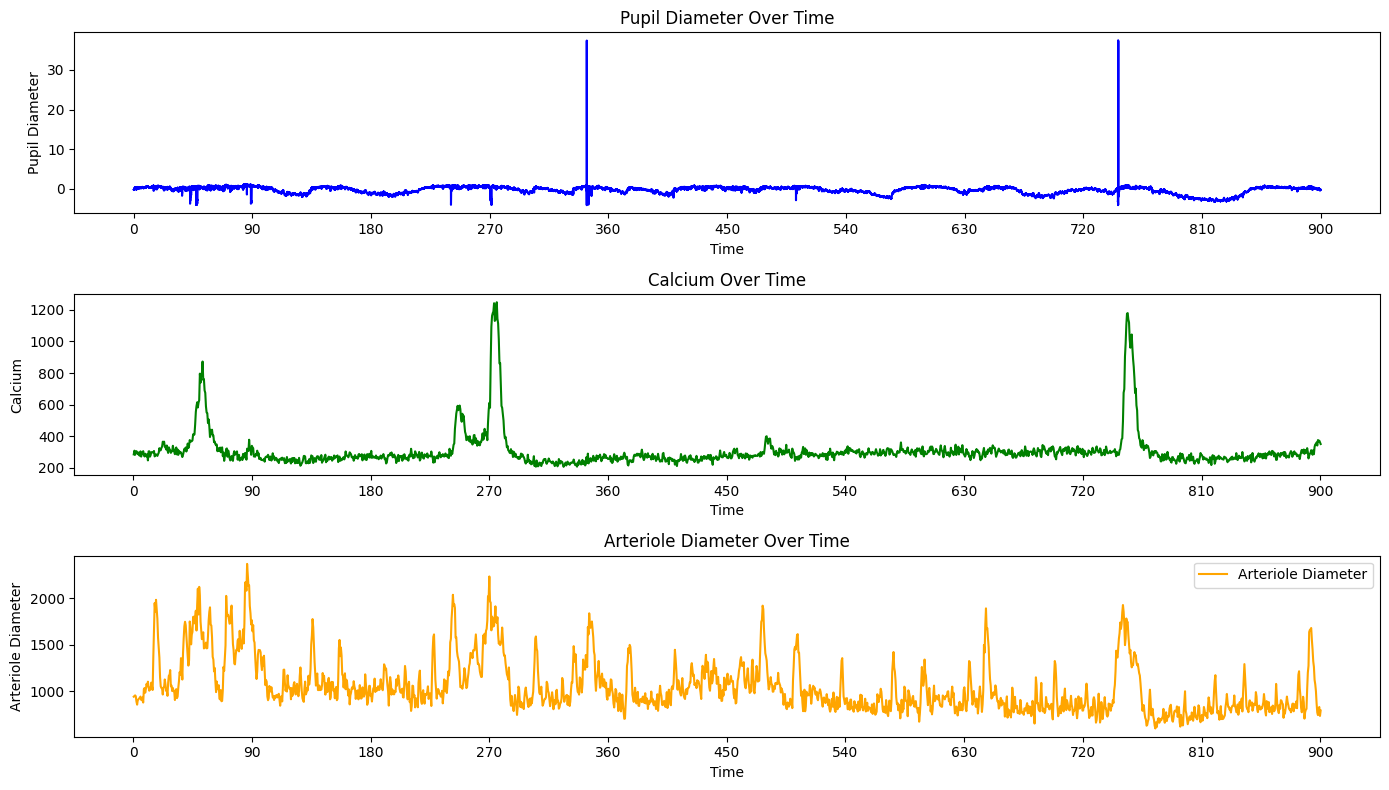

Whisker sampling rate:  50
Whisker sampling rate:  50
arteriole sampling rate:  2
pupil_sampling_rate:  50
calcium_sampling_rate:  2


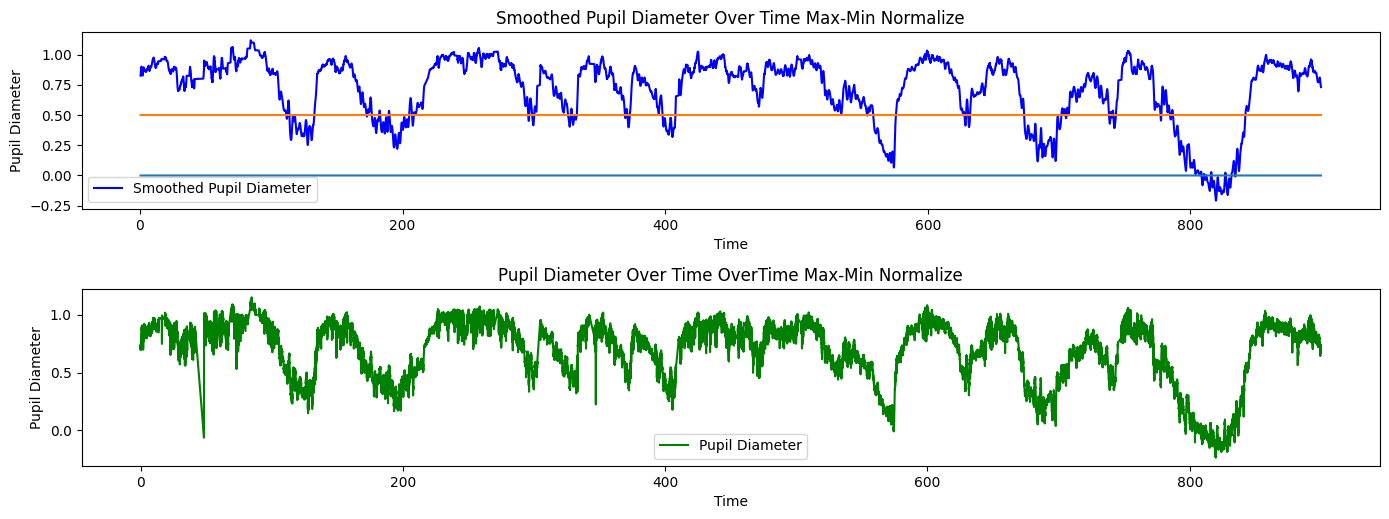

KeyboardInterrupt: 

In [ ]:
import os
import logging
from datetime import datetime

# Create results folder if it doesn't exist
os.makedirs('results', exist_ok=True)

# Setup logging configuration
log_file = os.path.join('results', 'log.txt')
logging.basicConfig(
    filename=log_file,
    level=logging.ERROR,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

for csv_folder in csv_folders:
    try:
        process_data(csv_folder,
            threshold_to_exclude_from_min_max=2.5,
            threshold_to_exclude_base_on_pupil=4,
            plot_traces = True,
            clear_output = False,
            bsline_length=5,
             event_length=25,
           results_folder="results_sep09")
    except Exception as e:
        logging.error(f"Error processing folder {csv_folder}: {e}")
        continue

In [ ]:
csv_folders

['data/barrel_cortex/2023.09.20/cycle_6',
 'data/barrel_cortex/2023.09.20/cycle_8',
 'data/barrel_cortex/2023.09.20/cycle_7',
 'data/barrel_cortex/2023.09.20/cycle_5',
 'data/barrel_cortex/2023.06.10/cycle_7',
 'data/barrel_cortex/2023.06.10/cycle_5',
 'data/barrel_cortex/2023.06.10/cycle_6',
 'data/barrel_cortex/2023.09.29/cycle_4',
 'data/barrel_cortex/2023.09.29/cycle_3',
 'data/barrel_cortex/2023.09.29/cycle_2 ',
 'data/restrosplenial_cortex/2023.05.07/cycle 5 ',
 'data/restrosplenial_cortex/2023.05.07/cycle 6 ',
 'data/restrosplenial_cortex/2023.05.07/cycle_7',
 'data/restrosplenial_cortex/2023.06.02/cycle_6',
 'data/restrosplenial_cortex/2023.06.02/cycle_5',
 'data/restrosplenial_cortex/2023.07.12/cycle_6',
 'data/restrosplenial_cortex/2023.07.12/cycle_7',
 'data/restrosplenial_cortex/2023.07.12/cycle_8',
 'data/restrosplenial_cortex/2023.05.05/cycle_3',
 'data/restrosplenial_cortex/2023.05.05/cycle_5',
 'data/restrosplenial_cortex/2023.05.05/cycle_4',
 'data/restrosplenial_corte

# New Section

In [ ]:
os.listdir("data/restrosplenial_cortex/2023.05.17")

['.DS_Store', 'cycle_8', 'cycle_9', 'cycle_10']

data/restrosplenial_cortex/2023.05.17/cycle_9
Loading arteriole
Sucessfully loaded arteriole
Loading arteriole
Sucessfully loaded arteriole
Loading pupil
Sucessfully loaded pupil
Loading whisker
Sucessfully loaded whisker
Loading whisker
Sucessfully loaded whisker
Whisker sampling rate:  50
Whisker sampling rate:  50
arteriole sampling rate:  2
pupil_sampling_rate:  50
calcium_sampling_rate:  2


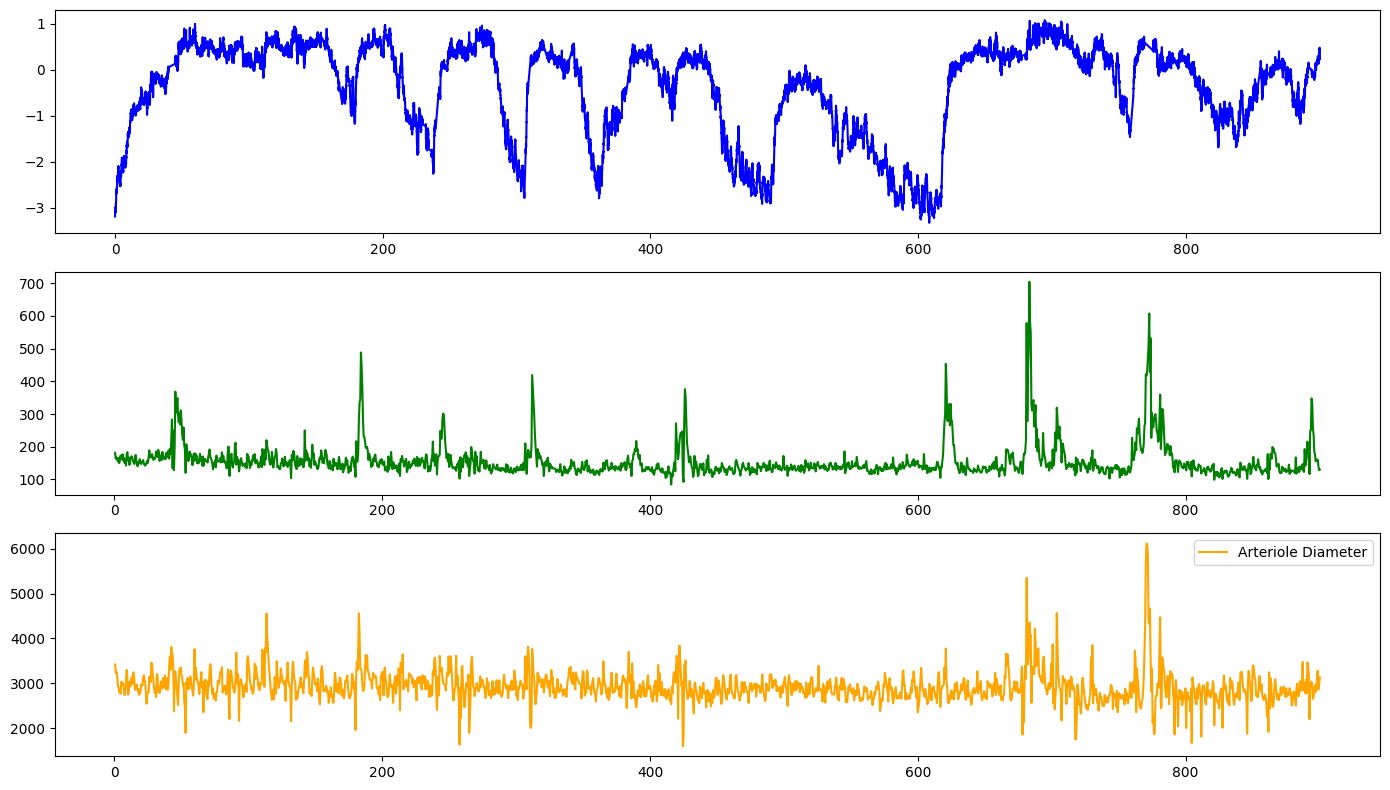

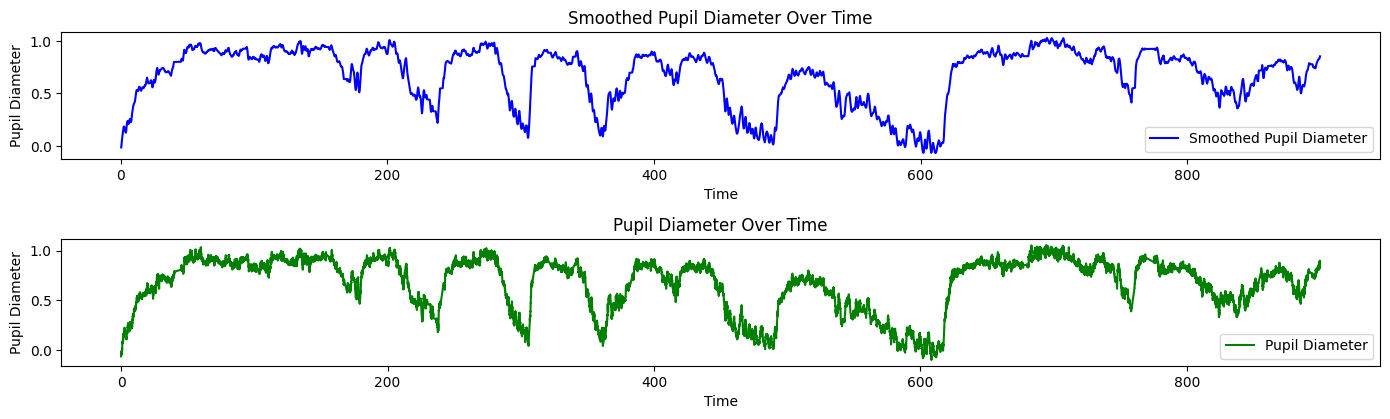

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


275
10961
14296
17464
23150
29439
None
pass find best event
Event 0 start time: 6.0
Event 1 start time: 236.98
Event 2 start time: 305.7
Event 3 start time: 375.42
Event 4 start time: 491.16
Event 5 start time: 616.94
[275, 10961, 14296, 17464, 23150, 29439]


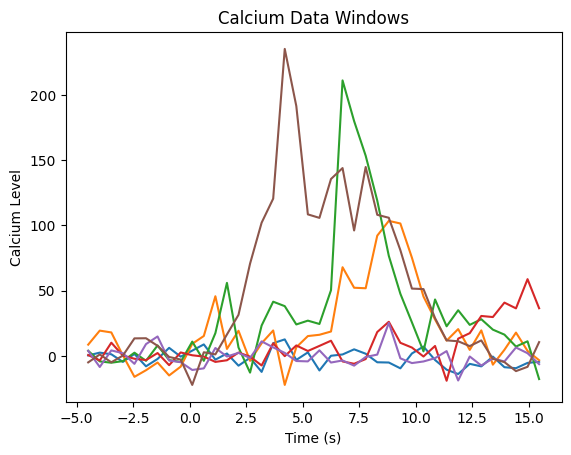

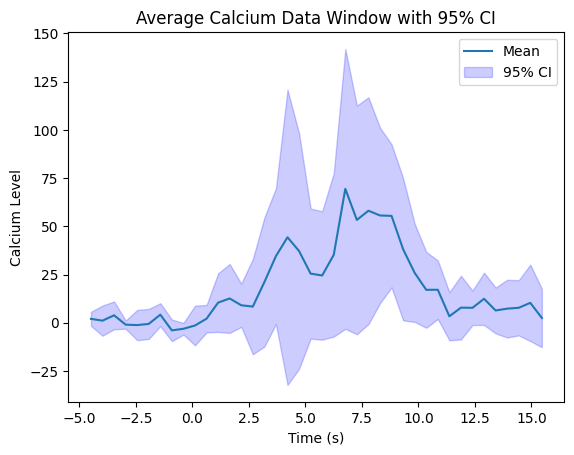

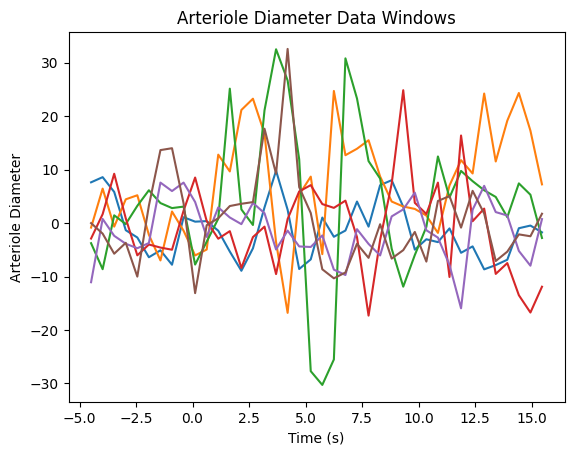

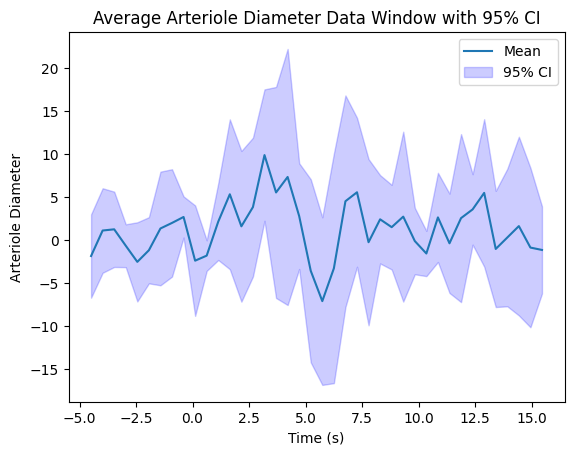

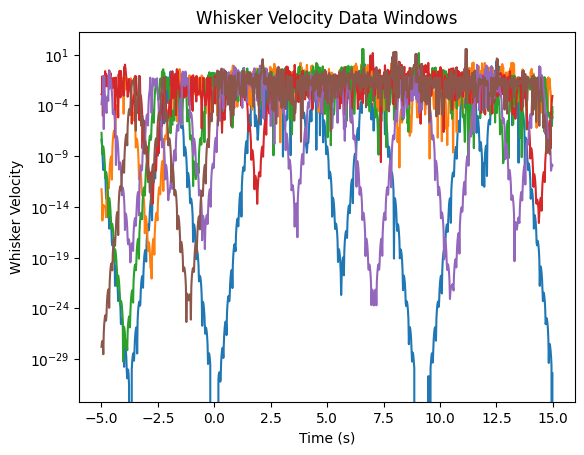

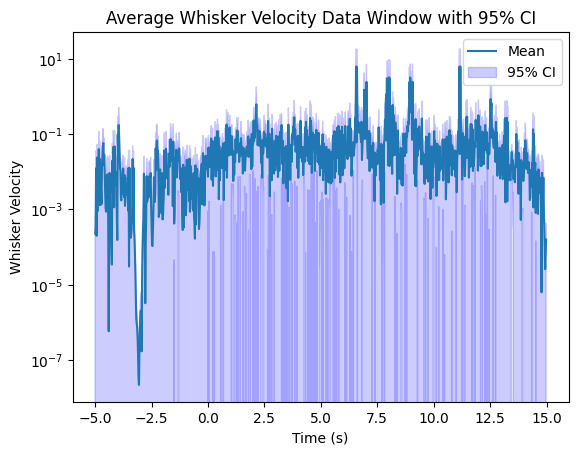

-0.10379916750562256 1.056386174006749
Event 0.1743088786851441
Event 0.23195988439189308
Event 0.3120597205167463
Event 0.1510912521035003
Event 0.2420397581823558
Event 0.31809972052830376


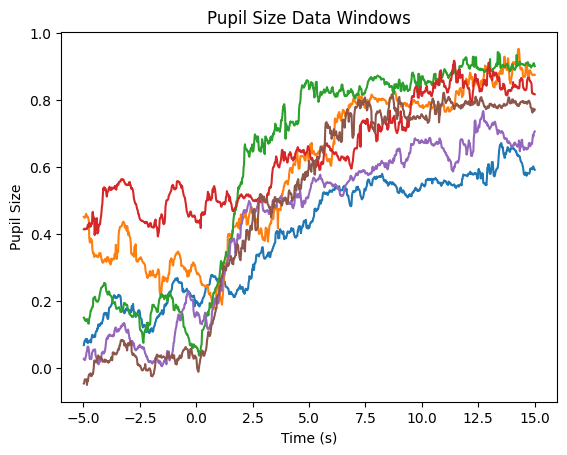

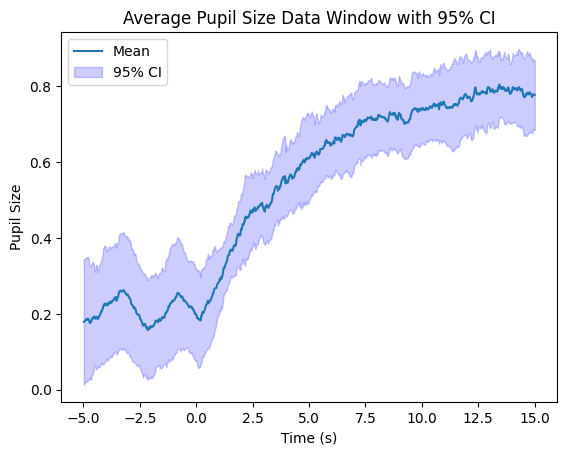

In [ ]:
data_folder_path = "data/restrosplenial_cortex/2023.05.17/cycle_9"
results_path = data_folder_path.replace('test','results')
results_path = data_folder_path.replace('data','results')
print(data_folder_path)
print("Loading arteriole")
arteriole_diameter_df = pd.read_csv(os.path.join(data_folder_path, 'arteriole_diameter.csv'))
# arteriole_diameter_df = arteriole_diameter_df.replace({'*': ''}, regex=True)
arteriole_diameter_df.columns = ['time', 'arteriole_diameter']
arteriole_diameter_df.dropna(inplace=True)
print("Sucessfully loaded arteriole")

print("Loading arteriole")
calcium_df = pd.read_csv(os.path.join(data_folder_path, 'calcium.csv'))
# calcium_df = calcium_df.replace({'*': ''}, regex=True)
calcium_df.columns = ['time', 'calcium']
calcium_df.dropna(inplace=True)
print("Sucessfully loaded arteriole")

print("Loading pupil")
pupil_size_df = pd.read_csv(os.path.join(data_folder_path, 'pupil_size.csv'))
# pupil_size_df = pupil_size_df.replace({'*': ''}, regex=True)
pupil_size_df.columns = ['time', 'pupil_size']
pupil_size_df.dropna(inplace=True)
pupil_size_normalize_df = normalize_mean_std(pupil_size_df)
interpolated_pupil_size_df = detect_and_interpolate_sudden_changes(pupil_size_normalize_df, 0.001, 1)
print("Sucessfully loaded pupil")


print("Loading whisker")
resampled_whisker_angle_df = pd.read_csv(os.path.join(data_folder_path, 'resampled_whiskerAngle.csv'), header=None)
# resampled_whisker_angle_df = resampled_whisker_angle_df.replace({'*': ''}, regex=True)
resampled_whisker_angle_df.dropna(inplace=True)
resampled_whisker_angle_df['time'] = np.linspace(0, 900, resampled_whisker_angle_df[0].shape[0])
resampled_whisker_angle_df.columns = ['whisker_angle','time']
print("Sucessfully loaded whisker")

print("Loading whisker")
filtered_whisker_angle_df = pd.read_csv(os.path.join(data_folder_path, 'filtered_whiskerAngle.csv'), header=None)
# filtered_whisker_angle_df = filtered_whisker_angle_df.replace({'*': ''}, regex=True)
filtered_whisker_angle_df.dropna(inplace=True)
filtered_whisker_angle_df['time'] = np.linspace(0, 900, filtered_whisker_angle_df[0].shape[0])
filtered_whisker_angle_df.columns = ['whisker_angle','time']
print("Sucessfully loaded whisker")

#calculate sampling rate
arteriole_sampling_rate = int(round(1 / np.mean(np.diff(arteriole_diameter_df['time']))))
calcium_sampling_rate = int(round(1 / np.mean(np.diff(calcium_df['time']))))
pupil_sampling_rate = int(round(1 / np.mean(np.diff(pupil_size_df['time']))))
resampled_whisker_sampling_rate = int(round(1 / np.mean(np.diff(resampled_whisker_angle_df['time']))))
whisker_sampling_rate = int(round(1 / np.mean(np.diff(filtered_whisker_angle_df['time']))))

print("Whisker sampling rate: ", resampled_whisker_sampling_rate)
print("Whisker sampling rate: ", whisker_sampling_rate)
print("arteriole sampling rate: ",arteriole_sampling_rate)
print("pupil_sampling_rate: ",pupil_sampling_rate)
print("calcium_sampling_rate: ",calcium_sampling_rate)


pupil_size_df_orig = pupil_size_df
pupil_size_df = interpolated_pupil_size_df

pupil_size_normalized = normalize_series(pupil_size_df_orig['pupil_size'].values)
pupil_time_normalized = pupil_size_df_orig['time'].values

window_size = pupil_sampling_rate
smoothed_pupil_size = moving_average(pupil_size_df['pupil_size'], window_size)
normalized_smoothed_pupil_size = normalize_series(smoothed_pupil_size)
smoothed_time_series = pupil_size_df['time'].values[int(window_size / 2) - 1:-int(window_size / 2)][:smoothed_pupil_size.shape[0]]


# Visualize pupil_size_df, arteriole_diameter_df, calcium_df, resampled_whisker_angle_df in 4 subplots
# and show the plot

plt.figure(figsize=(14, 8))
plt.subplot(3, 1, 1)
plt.plot(pupil_size_df['time'], pupil_size_df['pupil_size'], label='Pupil Diameter', color='blue')

plt.subplot(3, 1, 2)
plt.plot(calcium_df['time'], calcium_df['calcium'], label='Calcium', color='green')

plt.subplot(3, 1, 3)
plt.plot(arteriole_diameter_df['time'], arteriole_diameter_df['arteriole_diameter'], label='Arteriole Diameter', color='orange')

plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 8))
plt.subplot(4, 1, 1)
plt.plot(smoothed_time_series, normalized_smoothed_pupil_size, label='Smoothed Pupil Diameter', color='blue')
plt.xlabel('Time')
plt.ylabel('Pupil Diameter')
plt.title('Smoothed Pupil Diameter Over Time')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(pupil_size_df['time'], normalize_series(pupil_size_df['pupil_size'].values), label='Pupil Diameter', color='green')
plt.xlabel('Time')
plt.ylabel('Pupil Diameter')
plt.title('Pupil Diameter Over Time')
plt.legend()

plt.tight_layout()
plt.show()

pre_event_window=5*pupil_sampling_rate
event_window=25*pupil_sampling_rate
threshold=3
step=1

events, event_indices = detect_sudden_change_events(normalized_smoothed_pupil_size,
                                                    5,
                                                    pre_event_window,
                                                    event_window,
                                                    threshold,
                                                    step)
mask = np.zeros(smoothed_pupil_size.shape)

for idx, event_idx in enumerate(event_indices):
    zero_array = np.zeros(smoothed_pupil_size.shape)
    if event_idx == 1:
        zero_array[idx * step : idx * step + event_window + pre_event_window] = 1
    elif event_idx == 2:
        zero_array[idx * step: idx * step + event_window + pre_event_window] = -1
    mask += zero_array

filled_mask = fill_false_between_trues(mask > 0.5, 10 * pupil_sampling_rate)
consecutive_blocks = find_consecutive_true_blocks(filled_mask, pupil_sampling_rate)

# print(consecutive_blocks

cross_midline_blocks = []
for block in consecutive_blocks:
    if check_cross_midline(normalized_smoothed_pupil_size[block[0]:block[1]]):
        cross_midline_blocks.append(block)
        # plt.plot(smoothed_time_series[block[0]:block[1]], normalized_smoothed_pupil_size[block[0]:block[1]])
        # plt.show()


final_ranges = [np.max(normalized_smoothed_pupil_size[block[0]:block[1]]) - np.min(normalized_smoothed_pupil_size[block[0]:block[1]]) for block in cross_midline_blocks]
final_blocks = [cross_midline_blocks[i] for i in range(len(cross_midline_blocks)) if final_ranges[i] > 0.5]

whisker_time = filtered_whisker_angle_df['time'].values
whisker_angle = filtered_whisker_angle_df['whisker_angle'].values
normalized_whisker_velocity = normalize_series(np.power(calculate_derivative(whisker_angle, whisker_time),2))
whisker_time = whisker_time[:-1]

assert whisker_time.shape[0] == normalized_whisker_velocity.shape[0]

final_events = []

for block in final_blocks:
    best_event = find_best_events(block,
                                normalized_smoothed_pupil_size,
                                smoothed_time_series,
                                whisker_time,
                                normalized_whisker_velocity,
                                print_result=False,
                                plot_result=False)
    print(best_event)
    if best_event is not None:
        final_events.append(best_event)

print("pass find best event")

for idx, start_time in enumerate(final_events):
    print(f'Event {idx} start time: {smoothed_time_series[start_time]}')

integral_data = []

for event in final_events:
    time = smoothed_time_series[event]
    event_whisker_idx = (whisker_time < time).sum()
    baseline_whisker = normalized_whisker_velocity[event_whisker_idx - whisker_sampling_rate*bsline_length:event_whisker_idx]
    waking_up_whisker = normalized_whisker_velocity[event_whisker_idx:event_whisker_idx + whisker_sampling_rate * event_length]

    integral_baseline_whisker = np.trapz(baseline_whisker, whisker_time[event_whisker_idx - whisker_sampling_rate * bsline_length:event_whisker_idx]).mean()
    integral_waking_up_whisker = np.trapz(waking_up_whisker, whisker_time[event_whisker_idx:event_whisker_idx + whisker_sampling_rate * event_length]).mean()
    integral_ratio = integral_waking_up_whisker / integral_baseline_whisker
    integral_data.append(integral_ratio)

#only selecting the event that have the changes in whisker from low to high
waking_up_events = [event for idx, event in enumerate(final_events) if integral_data[idx] > 1.5]
print(waking_up_events)
results_path = data_folder_path.replace('test','results')
results_path = results_path.replace('data', 'results')
Path(results_path).mkdir(parents=True, exist_ok=True)

normalize = True
save_files = False

process_calcium_data(calcium_df, smoothed_time_series, waking_up_events, results_path, calcium_sampling_rate, normalize, save_files)
process_arteriole_data(arteriole_diameter_df, smoothed_time_series, waking_up_events, results_path, arteriole_sampling_rate, normalize, save_files)
process_whisker_data(normalized_whisker_velocity, whisker_time, smoothed_time_series, waking_up_events, results_path,whisker_sampling_rate, normalize, save_files)
# process_pupil_data(pupil_size_df_orig['pupil_size'].values, pupil_size_df_orig['time'].values, smoothed_time_series, waking_up_events, results_path, pupil_sampling_rate,normalize=True)
print(pupil_size_normalized.min(),pupil_size_normalized.max())
process_pupil_data(pupil_size_normalized, pupil_time_normalized, smoothed_time_series, waking_up_events, results_path, pupil_sampling_rate,normalize=False, save_files=save_files)
from IPython.display import clear_output
# clear_output()

data/restrosplenial_cortex/2023.05.17/cycle_9
Loading arteriole
Sucessfully loaded arteriole
Loading arteriole
Sucessfully loaded arteriole
Loading pupil
Sucessfully loaded pupil
Loading whisker
Sucessfully loaded whisker
Loading whisker
Sucessfully loaded whisker
Whisker sampling rate:  50
Whisker sampling rate:  50
arteriole sampling rate:  2
pupil_sampling_rate:  50
calcium_sampling_rate:  2


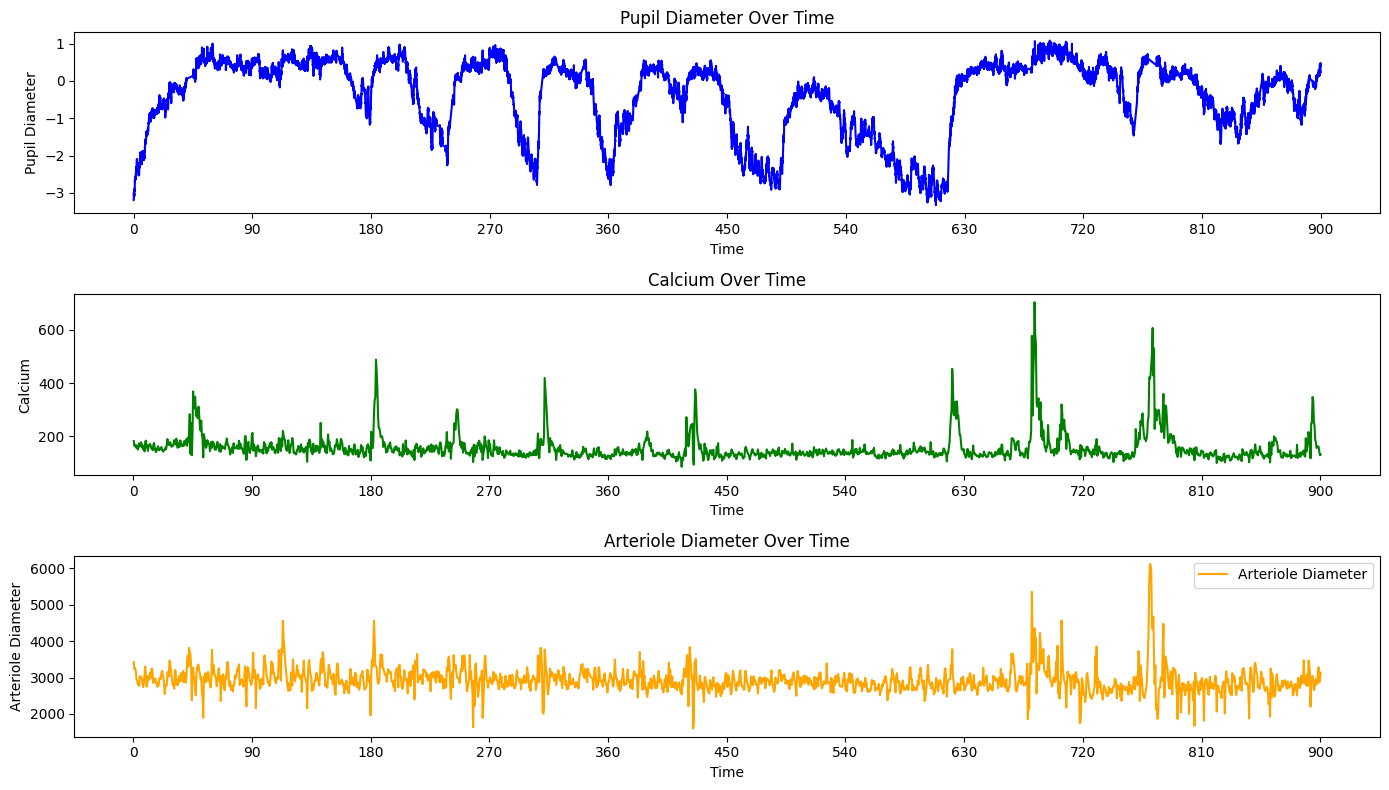

In [ ]:
data_folder_path = "data/restrosplenial_cortex/2023.05.17/cycle_9"
results_path = data_folder_path.replace('test','results')
results_path = data_folder_path.replace('data','results')
print(data_folder_path)
print("Loading arteriole")
arteriole_diameter_df = pd.read_csv(os.path.join(data_folder_path, 'arteriole_diameter.csv'))
# arteriole_diameter_df = arteriole_diameter_df.replace({'*': ''}, regex=True)
arteriole_diameter_df.columns = ['time', 'arteriole_diameter']
arteriole_diameter_df.dropna(inplace=True)
print("Sucessfully loaded arteriole")

print("Loading arteriole")
calcium_df = pd.read_csv(os.path.join(data_folder_path, 'calcium.csv'))
# calcium_df = calcium_df.replace({'*': ''}, regex=True)
calcium_df.columns = ['time', 'calcium']
calcium_df.dropna(inplace=True)
print("Sucessfully loaded arteriole")

print("Loading pupil")
pupil_size_df = pd.read_csv(os.path.join(data_folder_path, 'pupil_size.csv'))
# pupil_size_df = pupil_size_df.replace({'*': ''}, regex=True)
pupil_size_df.columns = ['time', 'pupil_size']
pupil_size_df.dropna(inplace=True)
pupil_size_normalize_df = normalize_mean_std(pupil_size_df)
interpolated_pupil_size_df = detect_and_interpolate_sudden_changes(pupil_size_normalize_df, 0.001, 1)
print("Sucessfully loaded pupil")


print("Loading whisker")
resampled_whisker_angle_df = pd.read_csv(os.path.join(data_folder_path, 'resampled_whiskerAngle.csv'), header=None)
# resampled_whisker_angle_df = resampled_whisker_angle_df.replace({'*': ''}, regex=True)
resampled_whisker_angle_df.dropna(inplace=True)
resampled_whisker_angle_df['time'] = np.linspace(0, 900, resampled_whisker_angle_df[0].shape[0])
resampled_whisker_angle_df.columns = ['whisker_angle','time']
print("Sucessfully loaded whisker")

print("Loading whisker")
filtered_whisker_angle_df = pd.read_csv(os.path.join(data_folder_path, 'filtered_whiskerAngle.csv'), header=None)
# filtered_whisker_angle_df = filtered_whisker_angle_df.replace({'*': ''}, regex=True)
filtered_whisker_angle_df.dropna(inplace=True)
filtered_whisker_angle_df['time'] = np.linspace(0, 900, filtered_whisker_angle_df[0].shape[0])
filtered_whisker_angle_df.columns = ['whisker_angle','time']
print("Sucessfully loaded whisker")

#calculate sampling rate
arteriole_sampling_rate = int(round(1 / np.mean(np.diff(arteriole_diameter_df['time']))))
calcium_sampling_rate = int(round(1 / np.mean(np.diff(calcium_df['time']))))
pupil_sampling_rate = int(round(1 / np.mean(np.diff(pupil_size_df['time']))))
resampled_whisker_sampling_rate = int(round(1 / np.mean(np.diff(resampled_whisker_angle_df['time']))))
whisker_sampling_rate = int(round(1 / np.mean(np.diff(filtered_whisker_angle_df['time']))))

print("Whisker sampling rate: ", resampled_whisker_sampling_rate)
print("Whisker sampling rate: ", whisker_sampling_rate)
print("arteriole sampling rate: ",arteriole_sampling_rate)
print("pupil_sampling_rate: ",pupil_sampling_rate)
print("calcium_sampling_rate: ",calcium_sampling_rate)


pupil_size_df_orig = pupil_size_df
pupil_size_df = interpolated_pupil_size_df

pupil_size_normalized = normalize_series(pupil_size_df_orig['pupil_size'].values)
pupil_time_normalized = pupil_size_df_orig['time'].values

window_size = pupil_sampling_rate
smoothed_pupil_size = moving_average(pupil_size_df['pupil_size'], window_size)
normalized_smoothed_pupil_size = normalize_series(smoothed_pupil_size)
smoothed_time_series = pupil_size_df['time'].values[int(window_size / 2) - 1:-int(window_size / 2)][:smoothed_pupil_size.shape[0]]


# Visualize pupil_size_df, arteriole_diameter_df, calcium_df, resampled_whisker_angle_df in 4 subplots
# and show the plot

plt.figure(figsize=(14, 8))
plt.subplot(3, 1, 1)
plt.plot(pupil_size_df['time'], pupil_size_df['pupil_size'], label='Pupil Diameter', color='blue')
plt.xlabel('Time')
plt.ylabel('Pupil Diameter')
plt.title('Pupil Diameter Over Time')
plt.xticks(np.linspace(0, 900, 11))

plt.subplot(3, 1, 2)
plt.plot(calcium_df['time'], calcium_df['calcium'], label='Calcium', color='green')
plt.xlabel('Time')
plt.ylabel('Calcium')
plt.title('Calcium Over Time')
plt.xticks(np.linspace(0, 900, 11))

plt.subplot(3, 1, 3)
plt.plot(arteriole_diameter_df['time'], arteriole_diameter_df['arteriole_diameter'], label='Arteriole Diameter', color='orange')
plt.xlabel('Time')
plt.ylabel('Arteriole Diameter')
plt.title('Arteriole Diameter Over Time')
plt.xticks(np.linspace(0, 900, 11))

plt.legend()
plt.tight_layout()
plt.show()

# visualize the segment of data based on the time_start and time_end



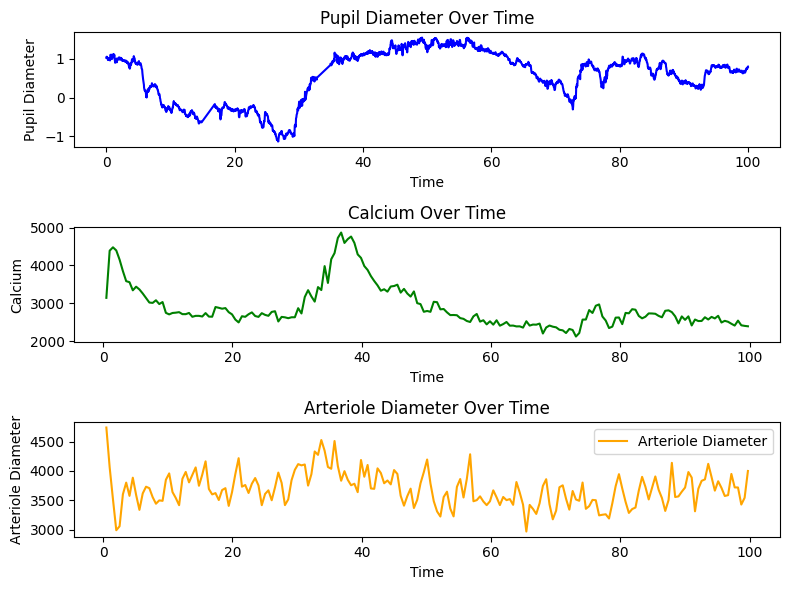

In [ ]:
time_start = 0
time_end = 100

calcium_time_idx = np.logical_and(calcium_df['time'].values > time_start, calcium_df['time'].values < time_end)
calcium_df_segment = calcium_df[calcium_time_idx]
arteriole_time_idx = np.logical_and(arteriole_diameter_df['time'].values > time_start, arteriole_diameter_df['time'].values < time_end)
arteriole_df_segment = arteriole_diameter_df[arteriole_time_idx]
pupil_time_idx = np.logical_and(pupil_size_df['time'].values > time_start, pupil_size_df['time'].values < time_end)
pupil_df_segment = pupil_size_df[pupil_time_idx]

#plot time segment

plt.figure(figsize=(8, 6))
plt.subplot(3, 1, 1)
plt.plot(pupil_df_segment['time'], pupil_df_segment['pupil_size'], label='Pupil Diameter', color='blue')
plt.xlabel('Time')
plt.ylabel('Pupil Diameter')
plt.title('Pupil Diameter Over Time')

plt.subplot(3, 1, 2)
plt.plot(calcium_df_segment['time'], calcium_df_segment['calcium'], label='Calcium', color='green')
plt.xlabel('Time')
plt.ylabel('Calcium')
plt.title('Calcium Over Time')

plt.subplot(3, 1, 3)
plt.plot(arteriole_df_segment['time'], arteriole_df_segment['arteriole_diameter'], label='Arteriole Diameter', color='orange')
plt.xlabel('Time')
plt.ylabel('Arteriole Diameter')
plt.title('Arteriole Diameter Over Time')

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def generate_troubleshooting_figure(data_folder_path):
    img_path = "images_troubleshooting"
    if not os.path.exists(img_path):
        os.makedirs(img_path)
    image_file = '_'.join(data_folder_path.split('/')) + '.png'
    image_path = os.path.join(img_path, image_file)
    print(image_path)

    print("Loading arteriole")
    arteriole_diameter_df = pd.read_csv(os.path.join(data_folder_path, 'arteriole_diameter.csv'))
    # arteriole_diameter_df = arteriole_diameter_df.replace({'*': ''}, regex=True)
    arteriole_diameter_df.columns = ['time', 'arteriole_diameter']
    arteriole_diameter_df.dropna(inplace=True)
    print("Sucessfully loaded arteriole")

    print("Loading arteriole")
    calcium_df = pd.read_csv(os.path.join(data_folder_path, 'calcium.csv'))
    # calcium_df = calcium_df.replace({'*': ''}, regex=True)
    calcium_df.columns = ['time', 'calcium']
    calcium_df.dropna(inplace=True)
    print("Sucessfully loaded arteriole")

    print("Loading pupil")
    pupil_size_df = pd.read_csv(os.path.join(data_folder_path, 'pupil_size.csv'))
    # pupil_size_df = pupil_size_df.replace({'*': ''}, regex=True)
    pupil_size_df.columns = ['time', 'pupil_size']
    pupil_size_df.dropna(inplace=True)
    pupil_size_normalize_df = normalize_mean_std(pupil_size_df)
    interpolated_pupil_size_df = detect_and_interpolate_sudden_changes(pupil_size_normalize_df, 0.001, 1)
    print("Sucessfully loaded pupil")


    print("Loading whisker")
    resampled_whisker_angle_df = pd.read_csv(os.path.join(data_folder_path, 'resampled_whiskerAngle.csv'), header=None)
    # resampled_whisker_angle_df = resampled_whisker_angle_df.replace({'*': ''}, regex=True)
    resampled_whisker_angle_df.dropna(inplace=True)
    resampled_whisker_angle_df['time'] = np.linspace(0, 900, resampled_whisker_angle_df[0].shape[0])
    resampled_whisker_angle_df.columns = ['whisker_angle','time']
    print("Sucessfully loaded whisker")

    print("Loading whisker")
    filtered_whisker_angle_df = pd.read_csv(os.path.join(data_folder_path, 'filtered_whiskerAngle.csv'), header=None)
    # filtered_whisker_angle_df = filtered_whisker_angle_df.replace({'*': ''}, regex=True)
    filtered_whisker_angle_df.dropna(inplace=True)
    filtered_whisker_angle_df['time'] = np.linspace(0, 900, filtered_whisker_angle_df[0].shape[0])
    filtered_whisker_angle_df.columns = ['whisker_angle','time']
    print("Sucessfully loaded whisker")

    #calculate sampling rate
    arteriole_sampling_rate = int(round(1 / np.mean(np.diff(arteriole_diameter_df['time']))))
    calcium_sampling_rate = int(round(1 / np.mean(np.diff(calcium_df['time']))))
    pupil_sampling_rate = int(round(1 / np.mean(np.diff(pupil_size_df['time']))))
    resampled_whisker_sampling_rate = int(round(1 / np.mean(np.diff(resampled_whisker_angle_df['time']))))
    whisker_sampling_rate = int(round(1 / np.mean(np.diff(filtered_whisker_angle_df['time']))))

    print("Whisker sampling rate: ", resampled_whisker_sampling_rate)
    print("Whisker sampling rate: ", whisker_sampling_rate)
    print("arteriole sampling rate: ",arteriole_sampling_rate)
    print("pupil_sampling_rate: ",pupil_sampling_rate)
    print("calcium_sampling_rate: ",calcium_sampling_rate)


    pupil_size_df_orig = pupil_size_df
    pupil_size_df = interpolated_pupil_size_df

    pupil_size_normalized = normalize_series(pupil_size_df_orig['pupil_size'].values)
    pupil_time_normalized = pupil_size_df_orig['time'].values

    window_size = pupil_sampling_rate
    smoothed_pupil_size = moving_average(pupil_size_df['pupil_size'], window_size)
    normalized_smoothed_pupil_size = normalize_series(smoothed_pupil_size)
    smoothed_time_series = pupil_size_df['time'].values[int(window_size / 2) - 1:-int(window_size / 2)][:smoothed_pupil_size.shape[0]]


    # Visualize pupil_size_df, arteriole_diameter_df, calcium_df, resampled_whisker_angle_df in 4 subplots
    # and show the plot

    figure = plt.figure(figsize=(14, 8))

    plt.subplot(3, 1, 1)
    plt.plot(pupil_size_df['time'], pupil_size_df['pupil_size'], label='Pupil Diameter', color='blue')
    plt.xlabel('Time')
    plt.ylabel('Pupil Diameter')
    plt.title('Pupil Diameter Over Time')
    plt.xticks(np.linspace(0, 900, 11))

    plt.subplot(3, 1, 2)
    plt.plot(calcium_df['time'], calcium_df['calcium'], label='Calcium', color='green')
    plt.xlabel('Time')
    plt.ylabel('Calcium')
    plt.title('Calcium Over Time')
    plt.xticks(np.linspace(0, 900, 11))

    plt.subplot(3, 1, 3)
    plt.plot(arteriole_diameter_df['time'], arteriole_diameter_df['arteriole_diameter'], label='Arteriole Diameter', color='orange')
    plt.xlabel('Time')
    plt.ylabel('Arteriole Diameter')
    plt.title('Arteriole Diameter Over Time')
    plt.xticks(np.linspace(0, 900, 11))

    plt.legend()
    plt.tight_layout()
    plt.show()

    #save_figure
    figure.savefig(image_path)

In [ ]:
#import logging
import os
from pathlib import Path
import logging
# Setup logging configuration
log_file = os.path.join('images_troubleshooting', 'log_images.txt')
logging.basicConfig(
    filename=log_file,
    level=logging.ERROR,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

for csv_folder in csv_folders:
    try:
        generate_troubleshooting_figure(csv_folder)
    except Exception as e:
        logging.error(f"Error processing folder {csv_folder}: {e}")
        continue

# generate_troubleshooting_figure(data_folder_path)

ERROR:root:Error processing folder data/restrosplenial_cortex/2023.05.05/cycle_3: name 'generate_troubleshooting_figure' is not defined




# Run individually

In [ ]:
list_of_folders = [
    'data/female_data_retrosplenial_cortex/2023.09.25/cycle_5',
    'data/female_data_retrosplenial_cortex/2023.09.25/cycle_6',
    'data/female_data_retrosplenial_cortex/2023.09.25/cycle_7',
    'data/female_data_retrosplenial_cortex/2024.03.20/cycle_6',
    'data/female_data_retrosplenial_cortex/2024.03.20/cycle_8',
]

In [ ]:
csv_folders

['data/barrel_cortex/2023.09.20/cycle_6',
 'data/barrel_cortex/2023.09.20/cycle_8',
 'data/barrel_cortex/2023.09.20/cycle_7',
 'data/barrel_cortex/2023.09.20/cycle_5',
 'data/barrel_cortex/2023.06.10/cycle_7',
 'data/barrel_cortex/2023.06.10/cycle_5',
 'data/barrel_cortex/2023.06.10/cycle_6',
 'data/barrel_cortex/2023.09.29/cycle_4',
 'data/barrel_cortex/2023.09.29/cycle_3',
 'data/barrel_cortex/2023.09.29/cycle_2 ',
 'data/restrosplenial_cortex/2023.05.07/cycle 5 ',
 'data/restrosplenial_cortex/2023.05.07/cycle 6 ',
 'data/restrosplenial_cortex/2023.05.07/cycle_7',
 'data/restrosplenial_cortex/2023.06.02/cycle_6',
 'data/restrosplenial_cortex/2023.06.02/cycle_5',
 'data/restrosplenial_cortex/2023.07.12/cycle_6',
 'data/restrosplenial_cortex/2023.07.12/cycle_7',
 'data/restrosplenial_cortex/2023.07.12/cycle_8',
 'data/restrosplenial_cortex/2023.05.05/cycle_3',
 'data/restrosplenial_cortex/2023.05.05/cycle_5',
 'data/restrosplenial_cortex/2023.05.05/cycle_4',
 'data/restrosplenial_corte

Loading arteriole
Sucessfully loaded arteriole
Loading arteriole
Sucessfully loaded arteriole
Loading pupil
Sucessfully loaded pupil
Loading whisker
Sucessfully loaded whisker
Loading whisker
Sucessfully loaded whisker


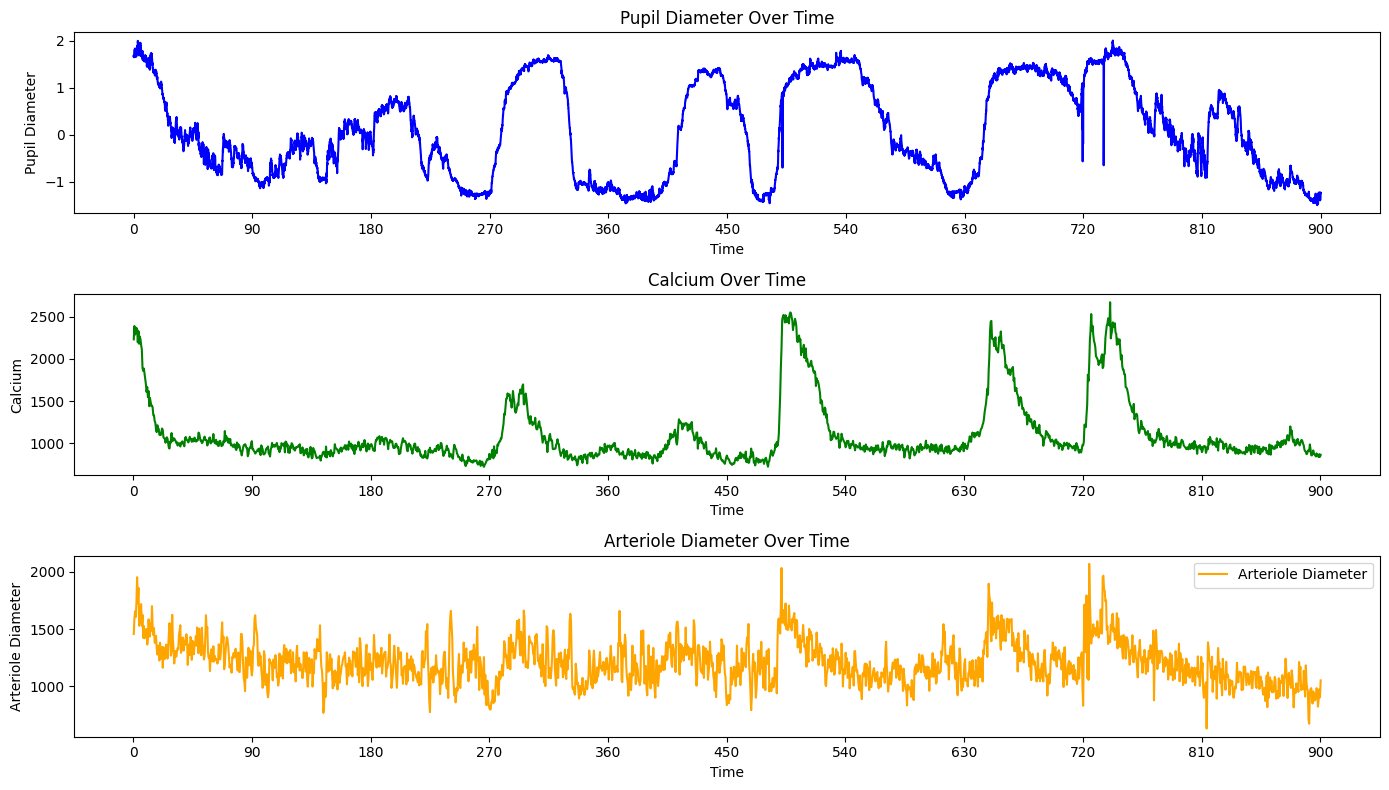

Whisker sampling rate:  50
Whisker sampling rate:  50
arteriole sampling rate:  2
pupil_sampling_rate:  40
calcium_sampling_rate:  2


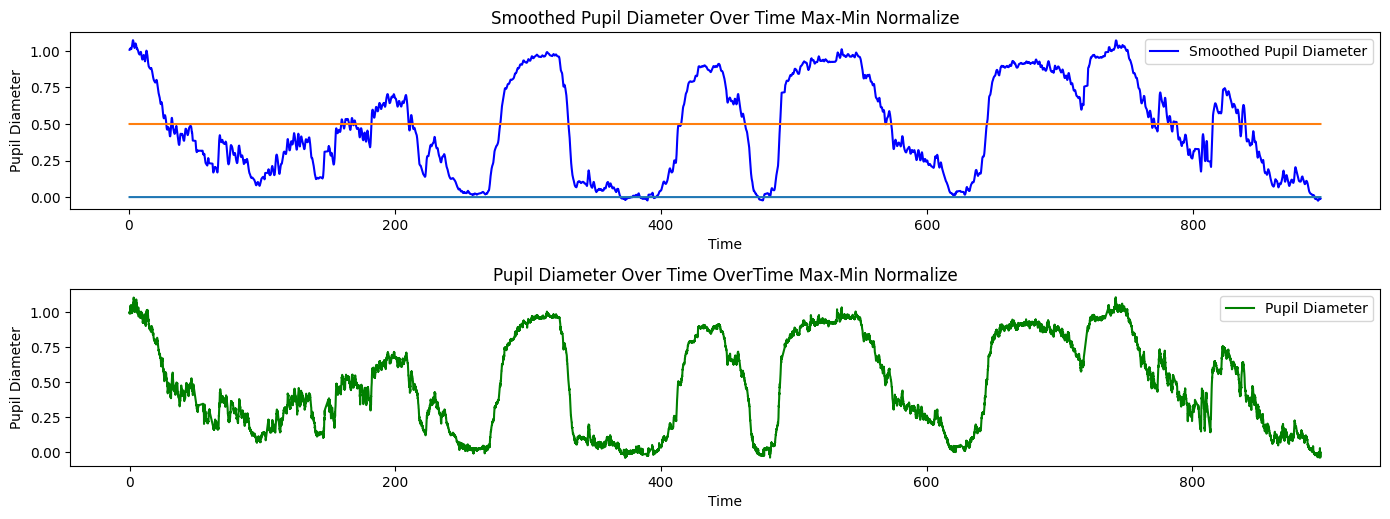

10303
15713
18662
24802
None
pass find best event
Event 0 start time: 270.725
Event 1 start time: 411.425
Event 2 start time: 485.15
Event 3 start time: 642.925
Event lower 0.12183449503765288
Event upper 0.8229665095672141
Event lower 0.4139571938217214
Event upper 0.8894144528046936
Event lower 0.09756846186418315
Event upper 0.8789923160154506
Event lower 0.38645566101286805
Event upper 0.8997568998283348


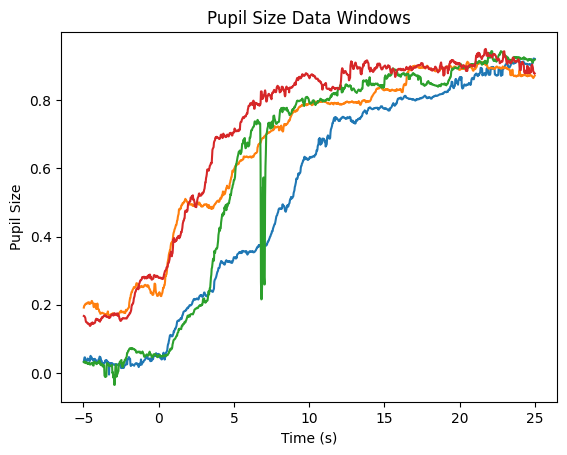

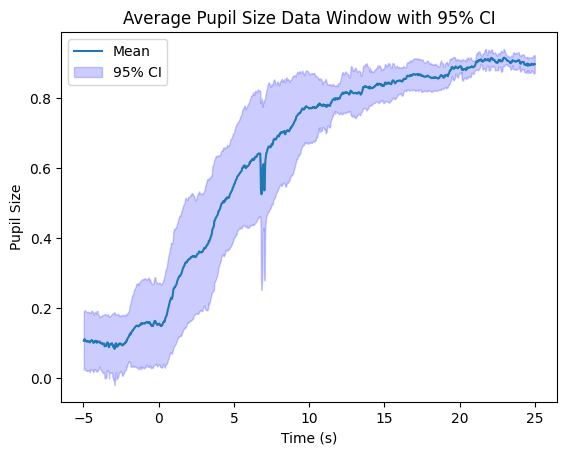

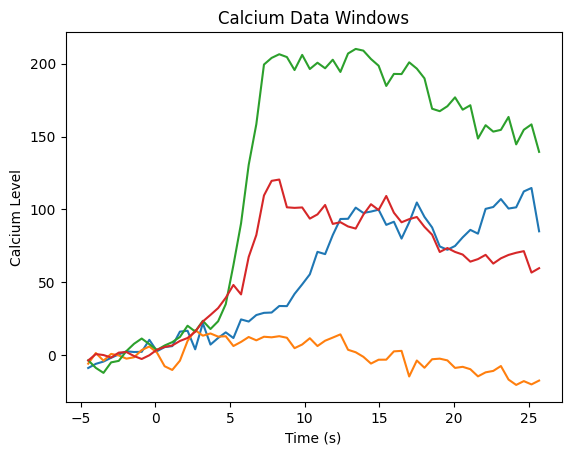

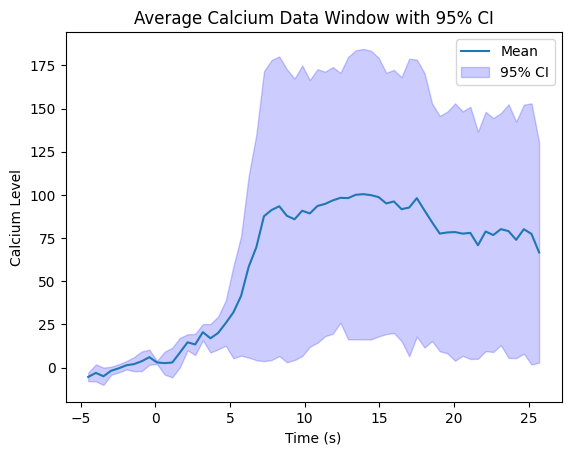

Calcium traces done!


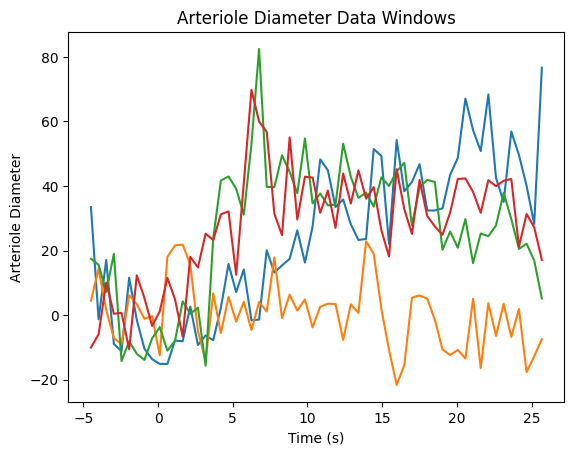

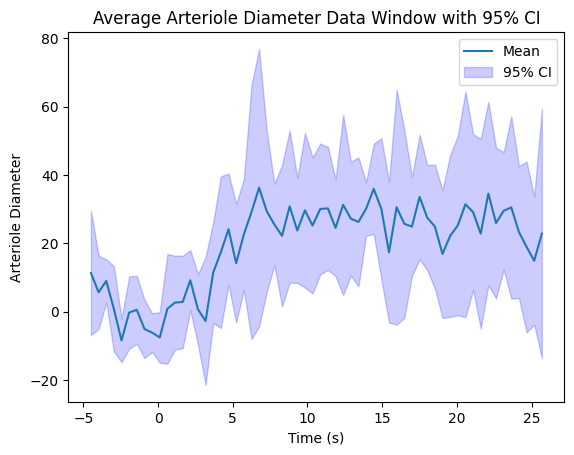

Arteriole traces done!
sucessfully save the arteriole traces to results_sep09/restrosplenial_cortex/2023.05.07/cycle_7


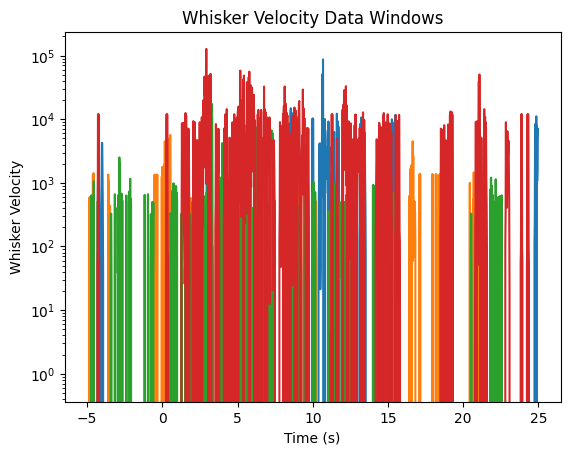

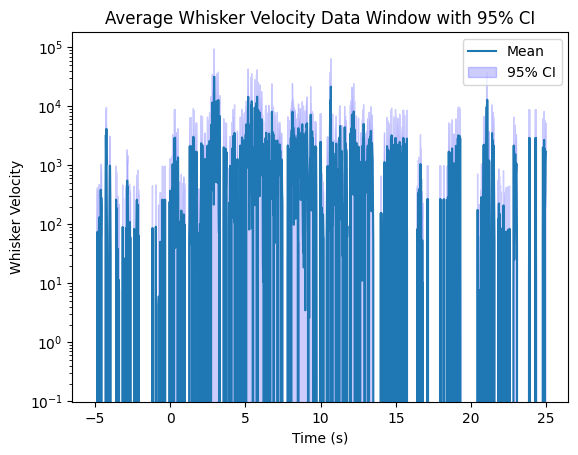

In [ ]:
# Folder containing CSV file: data/female_data_retrosplenial_cortex/2023.09.25/cycle_5
# Folder containing CSV file: data/female_data_retrosplenial_cortex/2023.09.25/cycle_6
# Folder containing CSV file: data/female_data_retrosplenial_cortex/2023.09.25/cycle_7
# Folder containing CSV file: data/female_data_retrosplenial_cortex/2024.03.20/cycle_6
# Folder containing CSV file: data/female_data_retrosplenial_cortex/2024.03.20/cycle_8
# Folder containing CSV file: data/female_data_retrosplenial_cortex/2024.03.20/cycle_9
# Folder containing CSV file: data/female_data_retrosplenial_cortex/2024.03.20/cycle_10
# Folder containing CSV file: data/female_data_retrosplenial_cortex/2024.03.22/cycle_7
# Folder containing CSV file: data/female_data_retrosplenial_cortex/2024.03.22/cycle_8
# Folder containing CSV file: data/female_data_retrosplenial_cortex/2024.03.22/cycle_9
csv_folder = ''
process_data("data/restrosplenial_cortex/2023.06.02/cycle_6",
            threshold_to_exclude_from_min_max=2.5,
            threshold_to_exclude_base_on_pupil=4,
            plot_traces = True,
            clear_ou.



             tput = False,
            bsline_length=5,
            event_length=25,
            results_folder="Results_Sep09")

In [ ]:
list_of_folders = [
    'data/female_data_retrosplenial_cortex/2023.09.25/cycle_5',
    'data/female_data_retrosplenial_cortex/2023.09.25/cycle_6',
    'data/female_data_retrosplenial_cortex/2023.09.25/cycle_7',
    'data/female_data_retrosplenial_cortex/2024.03.20/cycle_6',
    'data/female_data_retrosplenial_cortex/2024.03.20/cycle_8',
    'data/female_data_retrosplenial_cortex/2024.03.20/cycle_9',
    'data/female_data_retrosplenial_cortex/2024.03.20/cycle_10',
    'data/female_data_retrosplenial_cortex/2024.03.22/cycle_7',
    'data/female_data_retrosplenial_cortex/2024.03.22/cycle_8',
    'data/female_data_retrosplenial_cortex/2024.03.22/cycle_9',
]

In [ ]:
list_of_folders = [
    'data/female_data_retrosplenial_cortex/2023.09.25/cycle_5',
    'data/female_data_retrosplenial_cortex/2023.09.25/cycle_6',
    'data/female_data_retrosplenial_cortex/2023.09.25/cycle_7',
    'data/female_data_retrosplenial_cortex/2024.03.20/cycle_6',
    'data/female_data_retrosplenial_cortex/2024.03.20/cycle_8',
    'data/female_data_retrosplenial_cortex/2024.03.20/cycle_9',
    'data/female_data_retrosplenial_cortex/2024.03.20/cycle_10',
    'data/female_data_retrosplenial_cortex/2024.03.22/cycle_7',
    'data/female_data_retrosplenial_cortex/2024.03.22/cycle_8',
    'data/female_data_retrosplenial_cortex/2024.03.22/cycle_9',
]

In [ ]:
list_of_folders = [
    'data/female_data_retrosplenial_cortex/2023.09.25/cycle_5',
    'data/female_data_retrosplenial_cortex/2023.09.25/cycle_6',
    'data/female_data_retrosplenial_cortex/2023.09.25/cycle_7',
    'data/female_data_retrosplenial_cortex/2024.03.20/cycle_6',
    'data/female_data_retrosplenial_cortex/2024.03.20/cycle_8',
    'data/female_data_retrosplenial_cortex/2024.03.20/cycle_9',
    'data/female_data_retrosplenial_cortex/2024.03.20/cycle_10',
    'data/female_data_retrosplenial_cortex/2024.03.22/cycle_7',
    'data/female_data_retrosplenial_cortex/2024.03.22/cycle_8',
    'data/female_data_retrosplenial_cortex/2024.03.22/cycle_9',
]

In [ ]:
def find_folders_with_csv(root_folder):
    csv_folders = []
    for dirpath, dirnames, filenames in os.walk(root_folder):
        for file in filenames:
            if file.endswith('.csv'):
                print(f"Folder containing CSV file: {dirpath}")
                csv_folders.append(dirpath)
                break
    return csv_folders

# Specify the root folder
root_folder = "data/"
csv_folders = find_folders_with_csv(root_folder)

Folder containing CSV file: data/barrel_cortex/2023.09.20/cycle_6
Folder containing CSV file: data/barrel_cortex/2023.09.20/cycle_8
Folder containing CSV file: data/barrel_cortex/2023.09.20/cycle_7
Folder containing CSV file: data/barrel_cortex/2023.09.20/cycle_5
Folder containing CSV file: data/barrel_cortex/2023.06.10/cycle_7
Folder containing CSV file: data/barrel_cortex/2023.06.10/cycle_5
Folder containing CSV file: data/barrel_cortex/2023.06.10/cycle_6
Folder containing CSV file: data/barrel_cortex/2023.09.29/cycle_4
Folder containing CSV file: data/barrel_cortex/2023.09.29/cycle_3
Folder containing CSV file: data/barrel_cortex/2023.09.29/cycle_2 
Folder containing CSV file: data/restrosplenial_cortex/2023.05.07/cycle 5 
Folder containing CSV file: data/restrosplenial_cortex/2023.05.07/cycle 6 
Folder containing CSV file: data/restrosplenial_cortex/2023.05.07/cycle_7
Folder containing CSV file: data/restrosplenial_cortex/2023.06.02/cycle_6
Folder containing CSV file: data/restrosp

In [ ]:
csv_folder

'data/female_data_retrosplenial_cortex/2023.09.25/cycle_5'

In [ ]:
for csv_folder in list_of_folders:
    process_data(csv_folder)

NameError: name 'process_data' is not defined